In [366]:
library(readxl)
library(ggplot2)
library(lmtest)
library(sandwich)
library(car)

In [367]:
# Loading the data
data <- read_excel('Demanda de electricidad.xlsx', range='B3:P195')

# Removing unnecessary columns
data <- subset(data, select=c('Mes', 'Demanda Distribuidoras [GWh]', 
                              'Precio Monómico Medio Total Ajustado', 
                              'Precio Estacional Medio Total Ajustado',
                              'Temperatura Máxima Media CABA',
                              'Temperatura Mínima Media CABA',
                              'EMAE', 'Índice de Salarios Ajustado'))

# Removing rows with missing data
data <- data[data['Mes'] > '2010-12-01', ]

# Renaming columns to make the following code less verbose
colnames(data) <- c('date', 'demand', 'pmon', 'pest', 'tempmax', 'tempmin', 
                    'emae', 'wages')

# Multiplying the demand column by 1000 to keep units consistent
data$demand <- data$demand * 1000

# Calculating the subsidies required
data$true_subs <- (data$pmon - data$pest) * data$demand

# Showing some info about the data
sprintf("This table has %s rows", nrow(data))
sprintf("This table has %s columns", ncol(data))
head(data)
tail(data)

[1] "This table has 144 rows"

[1] "This table has 9 columns"

date,demand,pmon,pest,tempmax,tempmin,emae,wages,true_subs
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2011-01-01,8328000,234.3000,57.10000,30.6,20.9,133.0769,22.17006,1475721600
2011-02-01,7137000,232.8898,61.04206,28.6,19.4,129.5099,22.18267,1226477383
2011-03-01,7676000,244.3974,56.85902,27.4,17.6,147.0018,21.91699,1439544830
2011-04-01,6892000,249.2955,55.04414,23.7,14.1,151.0358,21.75415,1338780121
2011-05-01,7500000,396.3521,51.88676,19.0,10.7,166.1783,22.01193,2583490000
2011-06-01,8153000,455.6880,46.75123,15.6,8.4,156.6937,22.49493,3334061642


date,demand,pmon,pest,tempmax,tempmin,emae,wages,true_subs
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2022-07-01,10698000,412.0036,117.9212,16.4,8.8,151.2415,17.08702,3146093407
2022-08-01,9825000,324.9233,112.6810,18.5,9.0,150.2282,17.01510,2085280589
2022-09-01,8354000,270.8855,124.9911,20.9,10.8,148.1328,17.10533,1218801207
2022-10-01,8247000,173.0967,123.6402,23.3,13.0,146.2924,16.91122,407867286
2022-11-01,9286000,219.4823,123.4025,28.3,17.7,147.7913,17.20021,892197068
2022-12-01,11034000,258.8507,113.6311,30.5,19.7,145.7290,17.22331,1602352653


In [368]:
# Defining a few useful functions

scatter_plot <- function(y, x) {
    ggplot(data, aes_string(x=x, y=y)) +
           geom_point() 
}

build_formula <- function(predicted, predictors) {
    form_str <- paste(predicted, ' ~ ', sep='')
    for (i in predictors) {
        var_str <- paste(i, ' + ', sep='')
        form_str <- paste(form_str, var_str, sep='')
    }
    form_str <- substr(form_str, 1, nchar(form_str)-3)
    return(form_str)
}

build_model <- function(form_str, data, show=TRUE) {
    model <- lm(form_str, data)
    if (show){
        print(summary(model))
    }
    return(model)
}

reset_test <- function(model) { 
    resettest(model, power = 3, type = "fitted", data = data)
}

heterosk_test <- function(model) {
    p <- bptest(model)$p.value
    print(sprintf('The p-value of the Breusch-Pagan test is %s', p))
    ggplot(model, aes(x = .fitted, y = .resid)) +
        geom_point() +
        geom_hline(yintercept = 0, colour='red') +
        labs(y='Residual', x='Demanda Predicha')
}

autocorr_test <- function(model, data) {
    print(durbinWatsonTest(model))
    data$resid <- model$residuals
    print(ggplot(data, aes_string(x='date', y='resid')) +
           geom_point() + 
           labs(y='Residual', x='t'))
    data <- subset(data, select = 'resid')
}

res_dist <- function(model) {
    print(shapiro.test(model$residuals))
    ggplot(model, aes(x=.resid)) + 
    geom_histogram(aes(y=after_stat(density)), colour="black", fill="white") +
    geom_density(alpha=.2, fill="#FF6666") + 
    labs(y='', x='Residuos')    
}

pred_intervals <- function(truecol, model, predictors, data){
    predictors_df <- data[, predictors]
    preds <- data.frame(predict(model, newdata=predictors_df, 
                                interval='predict'))
    preds$true <- as.numeric(unlist(data[, truecol]))

    # Plotting the prediction interval
    ggplot(preds, aes(x=fit, y=true)) +
        geom_point() + 
        geom_line(aes(y = lwr), col = "coral2", linetype = "dashed") + 
        geom_line(aes(y = upr), col = "coral2", linetype = "dashed") + 
        geom_smooth(method=lm) +
        labs(y='Demanda Real', x='Demanda Predicha')
}

build_subs_model <- function(model, data) {
    data$est_subs <- (data$pmon - data$pest) * model$fitted / 1000
    data$true_subs <- data$true_subs / 1000
    subs_model <- lm(true_subs ~ est_subs, data)
    print(summary(subs_model))
    return(subs_model)
}

calc_plot_subs_errors <- function(model, data){
    # Calculating errors 
    data$est_subs <- (data$pmon - data$pest) * model$fitted
    data$error <- data$true_subs - data$est_subs
    data$ae <- abs(data$error)
    data$pe <- data$error / data$true_subs * 100
    data$ape <- abs(data$pe)

    # Printing MAE
    mae <- mean(data$ae)
    print(sprintf('The MAE for the subsidies estimator is %s', mae))

    # Printing MAPE
    mape <- mean(data$ape)
    print(sprintf('The MAPE for the subsidies estimator is %s', mape))

    # Printing max and min errors for both types
    print(sprintf('Max error is %s', max(data$error)))
    print(sprintf('Min error is %s', min(data$error)))
    print(sprintf('Max percentage error is %s', max(data$pe)))
    print(sprintf('Min percentage error is %s', min(data$pe)))

    # Plotting error over time
    print(ggplot(data, aes(x=date, y=error)) +
          geom_bar(stat="identity") +
          labs(y='Error', x='t'))
    
    # Plotting absolute error over time
    print(ggplot(data, aes(x=date, y=ae)) +
          geom_bar(stat="identity") +
          labs(y='Error Absoluto', x='t'))

    # Plotting percentage error over time
    print(ggplot(data, aes(x=date, y=pe)) + 
          geom_bar(stat="identity") + 
          labs(y='Error Porcentual', x='t'))

    # Plotting APE over time
    print(ggplot(data, aes(x=date, y=ape)) + 
          geom_bar(stat="identity") + 
          labs(y='Error Porcentual Absoluto', x='t'))
}

## Baseline model: only using time data

date,demand,pmon,pest,tempmax,tempmin,emae,wages,true_subs,t
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
2011-01-01,8328000,234.3000,57.10000,30.6,20.9,133.0769,22.17006,1475721600,1
2011-02-01,7137000,232.8898,61.04206,28.6,19.4,129.5099,22.18267,1226477383,2
2011-03-01,7676000,244.3974,56.85902,27.4,17.6,147.0018,21.91699,1439544830,3
2011-04-01,6892000,249.2955,55.04414,23.7,14.1,151.0358,21.75415,1338780121,4
2011-05-01,7500000,396.3521,51.88676,19.0,10.7,166.1783,22.01193,2583490000,5
2011-06-01,8153000,455.6880,46.75123,15.6,8.4,156.6937,22.49493,3334061642,6


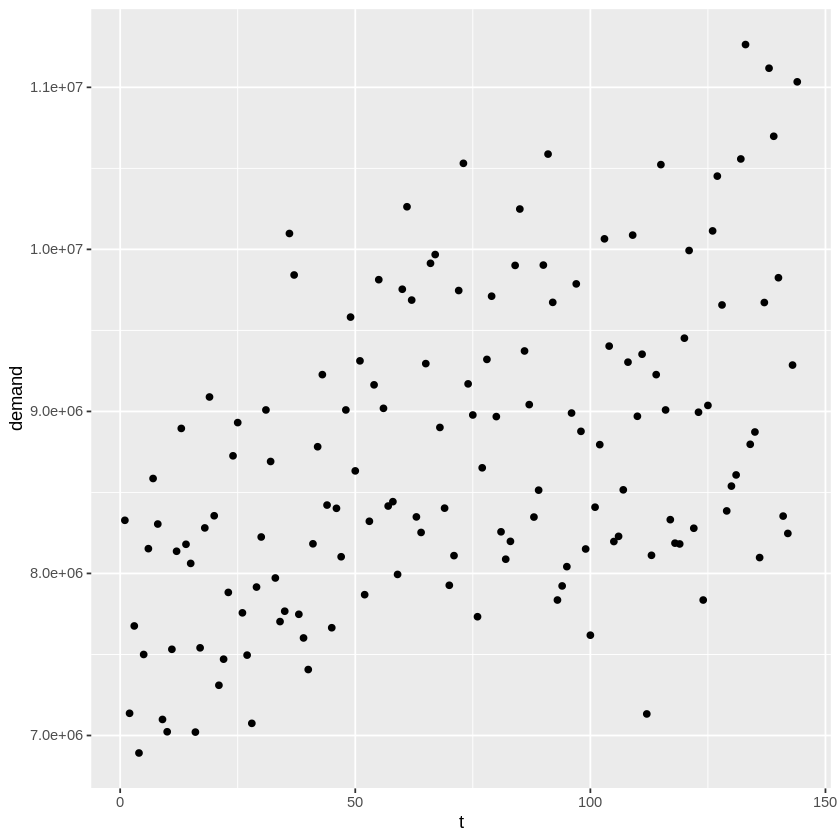

In [369]:
data$t = seq.int(nrow(data))
head(data)
scatter_plot('demand', 't')

In [370]:
predictors <- c('t')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-2029494  -637871  -126667   640550  1871060 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7933446     140920  56.297  < 2e-16 ***
t              10974       1686   6.508 1.22e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 841100 on 142 degrees of freedom
Multiple R-squared:  0.2297,	Adjusted R-squared:  0.2243 
F-statistic: 42.35 on 1 and 142 DF,  p-value: 1.22e-09



In [371]:
reset_test(model)


	RESET test

data:  model
RESET = 3.8431, df1 = 1, df2 = 141, p-value = 0.05192


[1] "The p-value of the Breusch-Pagan test is 0.0035097898409729"


 lag Autocorrelation D-W Statistic p-value
   1       0.3872942      1.200939       0
 Alternative hypothesis: rho != 0


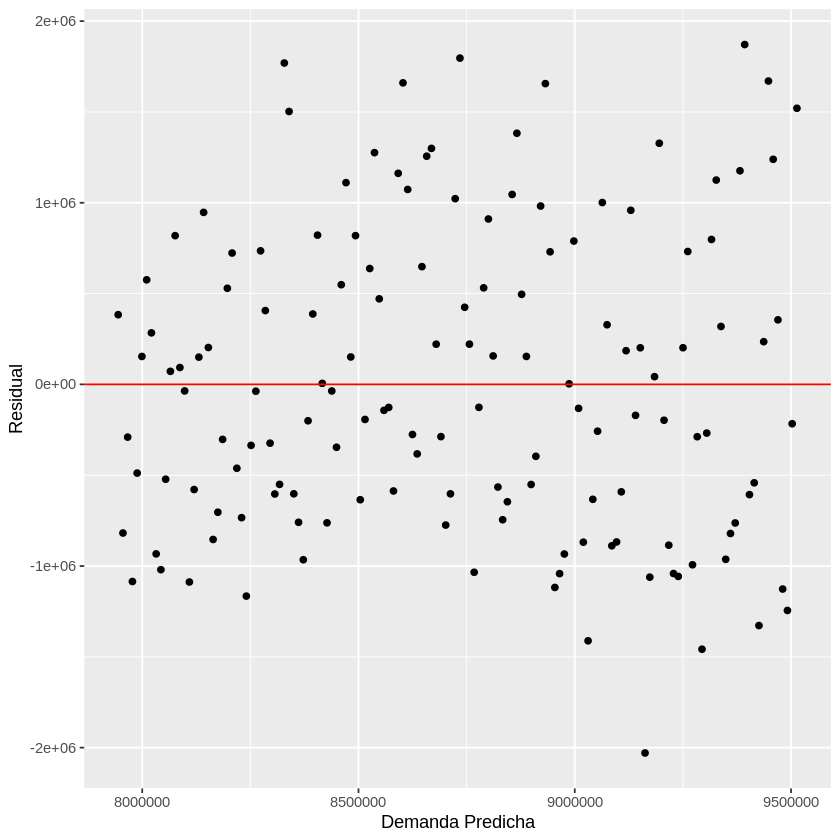

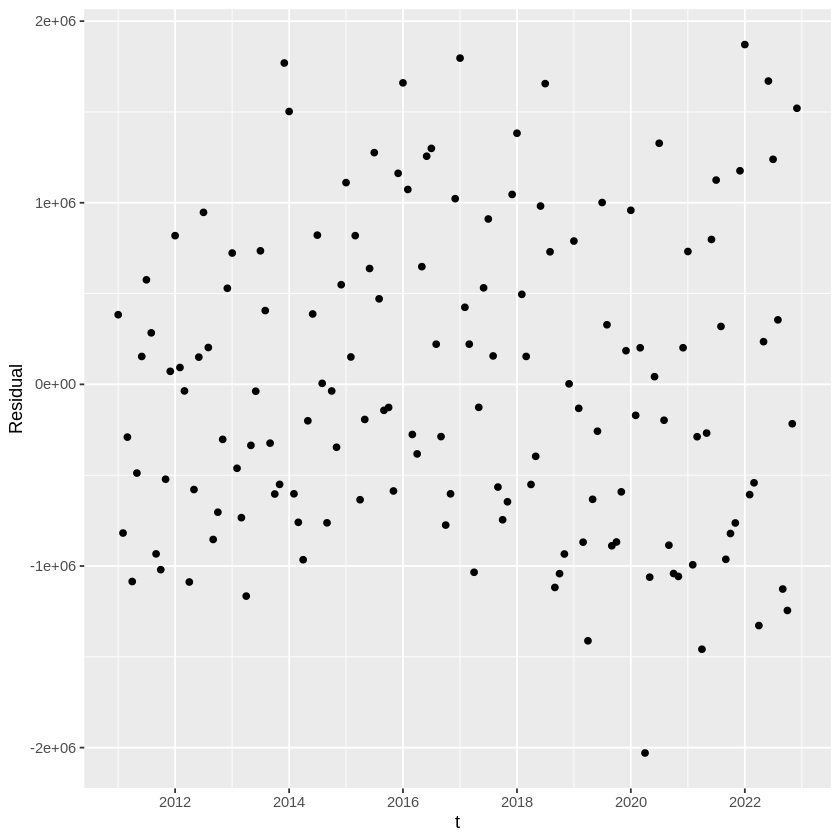

In [372]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.97483, p-value = 0.009347



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


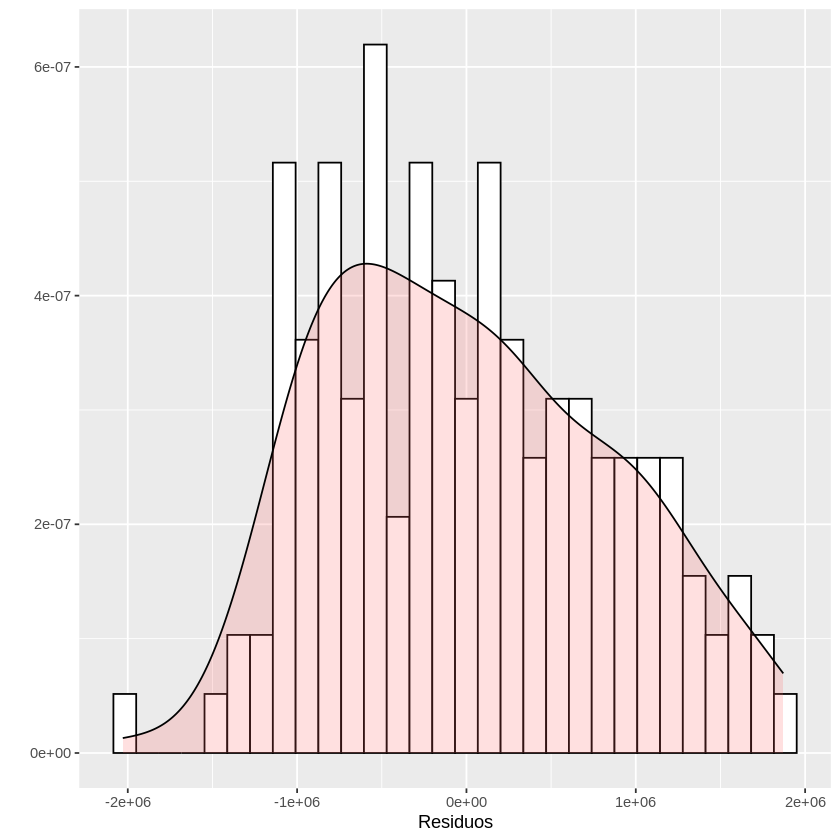

In [373]:
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


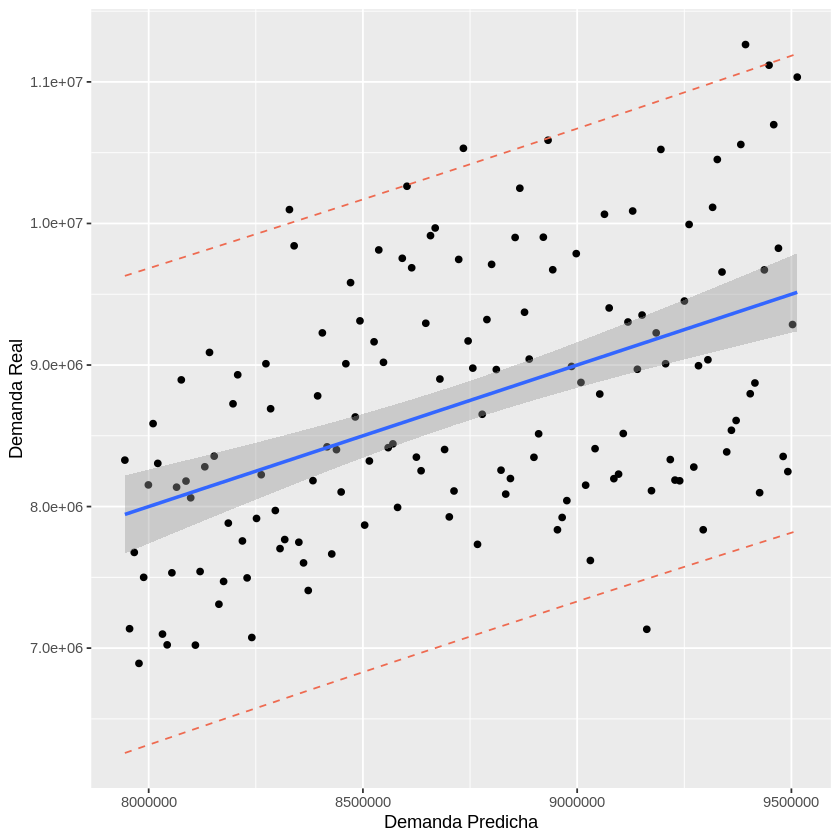

In [374]:
pred_intervals('demand', model, predictors, data)

In [375]:
subs_model <- build_subs_model(model, data)


Call:
lm(formula = true_subs ~ est_subs, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-313146  -89919  -10550   93970  332926 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.278e+05  3.235e+04   -3.95 0.000123 ***
est_subs     1.099e+00  2.118e-02   51.88  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 134400 on 142 degrees of freedom
Multiple R-squared:  0.9499,	Adjusted R-squared:  0.9495 
F-statistic:  2692 on 1 and 142 DF,  p-value: < 2.2e-16



[1] "The p-value of the Breusch-Pagan test is 4.02874217302772e-05"
 lag Autocorrelation D-W Statistic p-value
   1       0.3956018      1.190114       0
 Alternative hypothesis: rho != 0


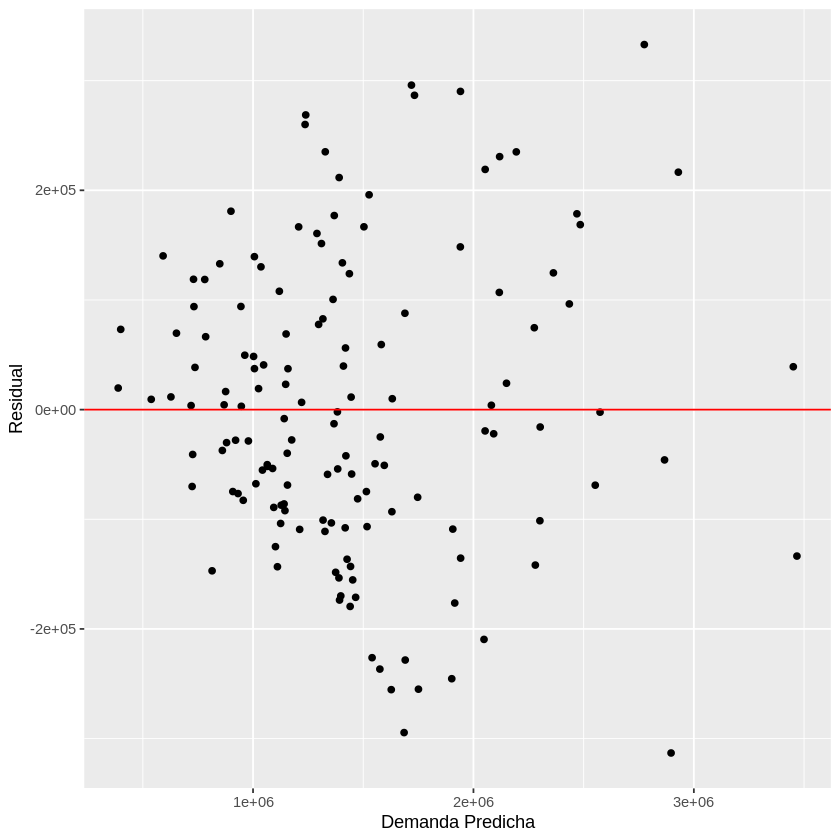

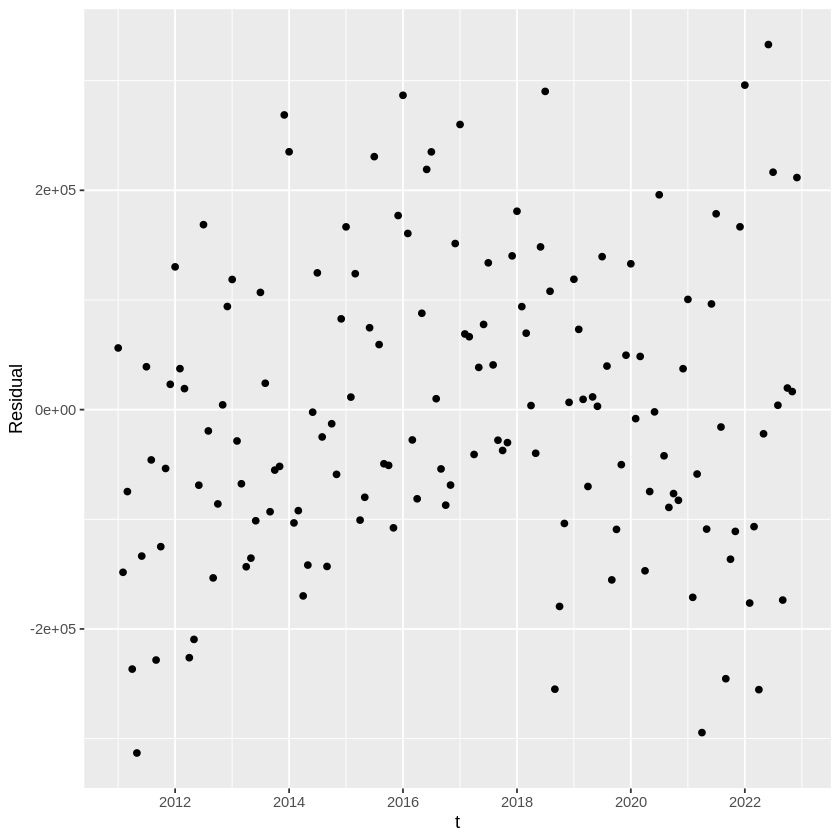

In [376]:
heterosk_test(subs_model)
autocorr_test(subs_model, data)

[1] "The MAE for the subsidies estimator is 114434159.048808"
[1] "The MAPE for the subsidies estimator is 8.0164165828727"
[1] "Max error is 466913445.335219"
[1] "Min error is -258818668.556035"
[1] "Max percentage error is 17.5233035823986"
[1] "Min percentage error is -28.4521739094342"


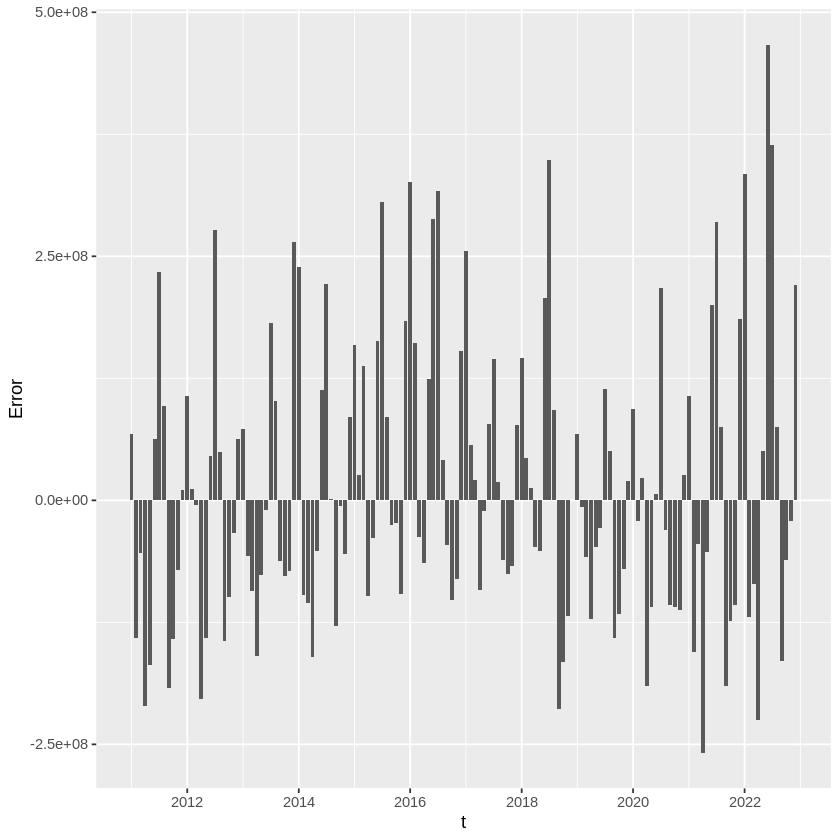

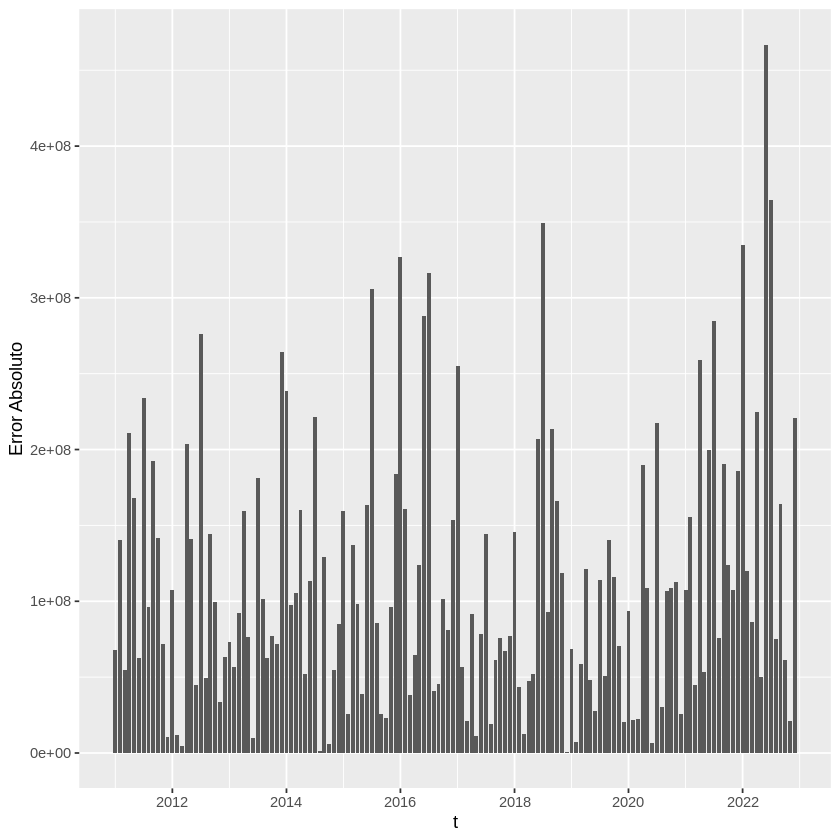

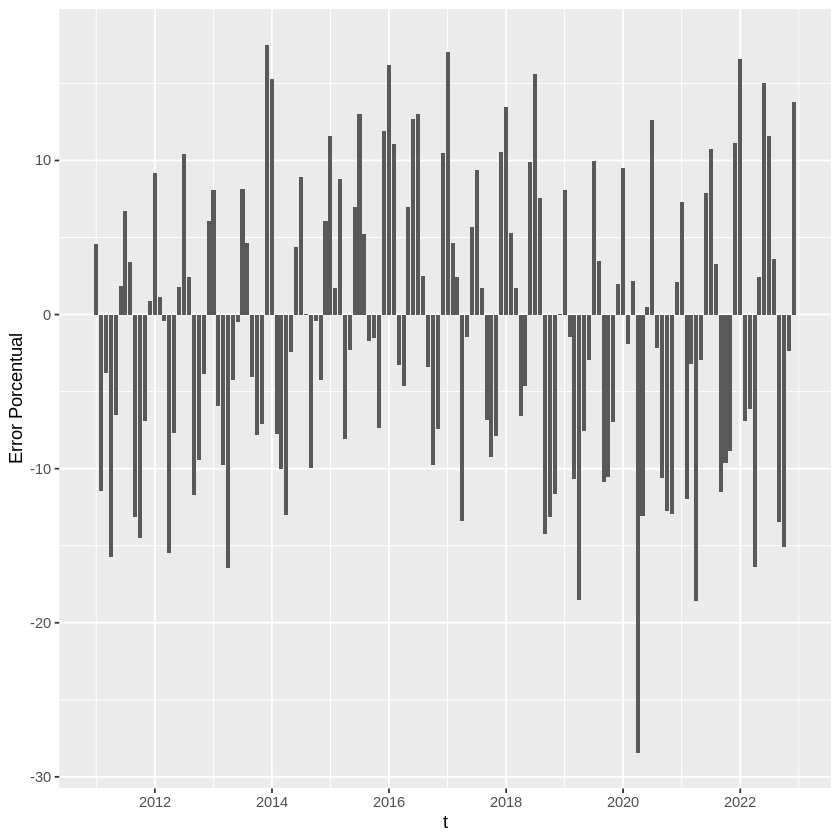

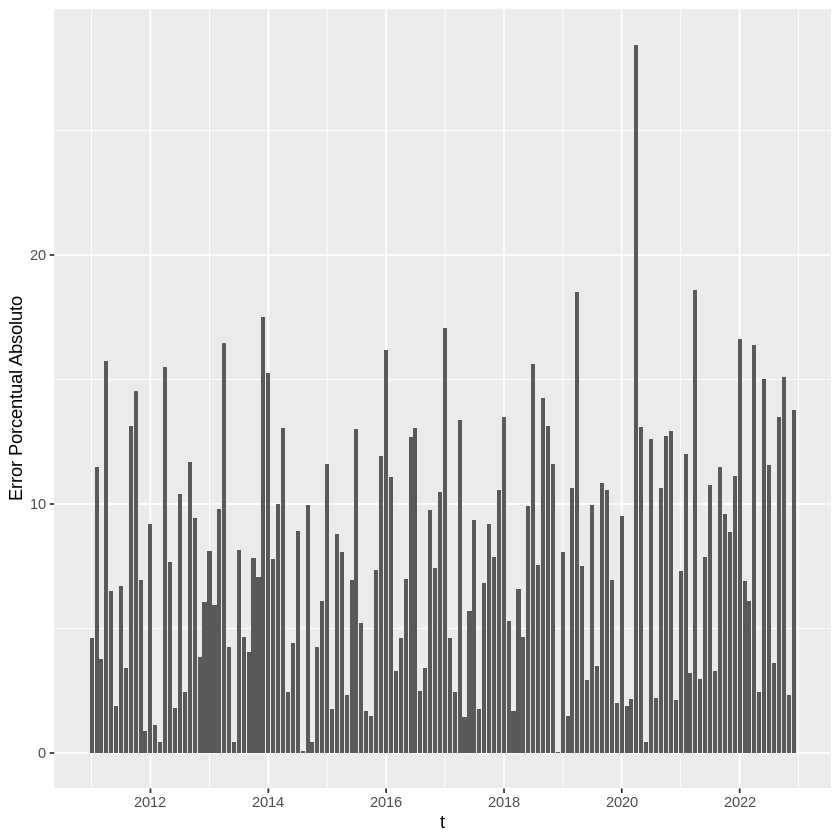

In [319]:
calc_plot_subs_errors(model, data)

## Model 2: Adding temperature data

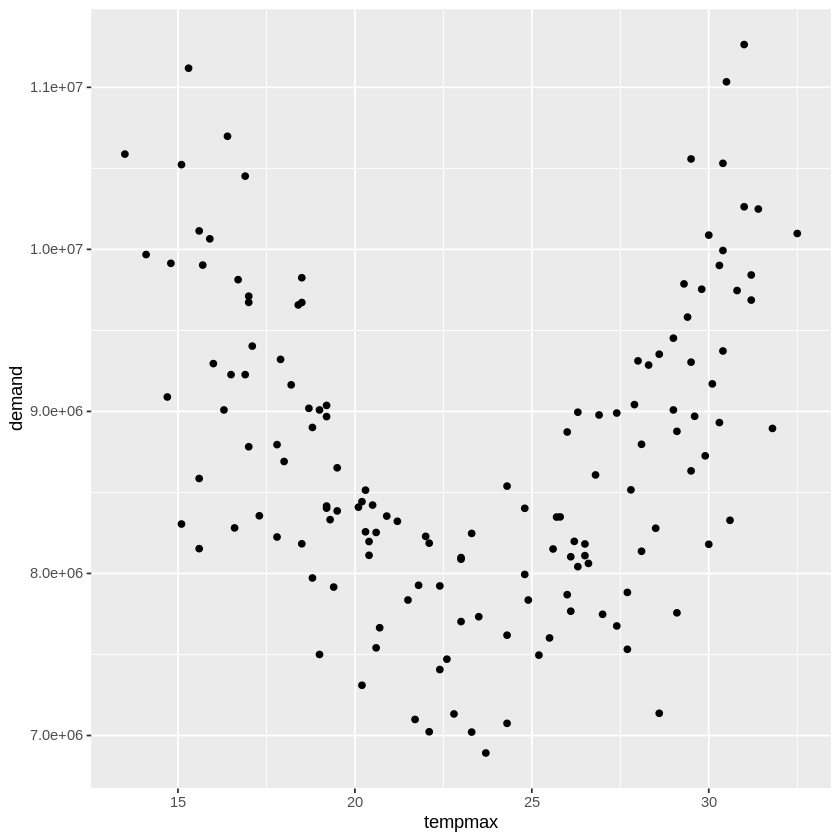

In [320]:
scatter_plot('demand', 'tempmax')

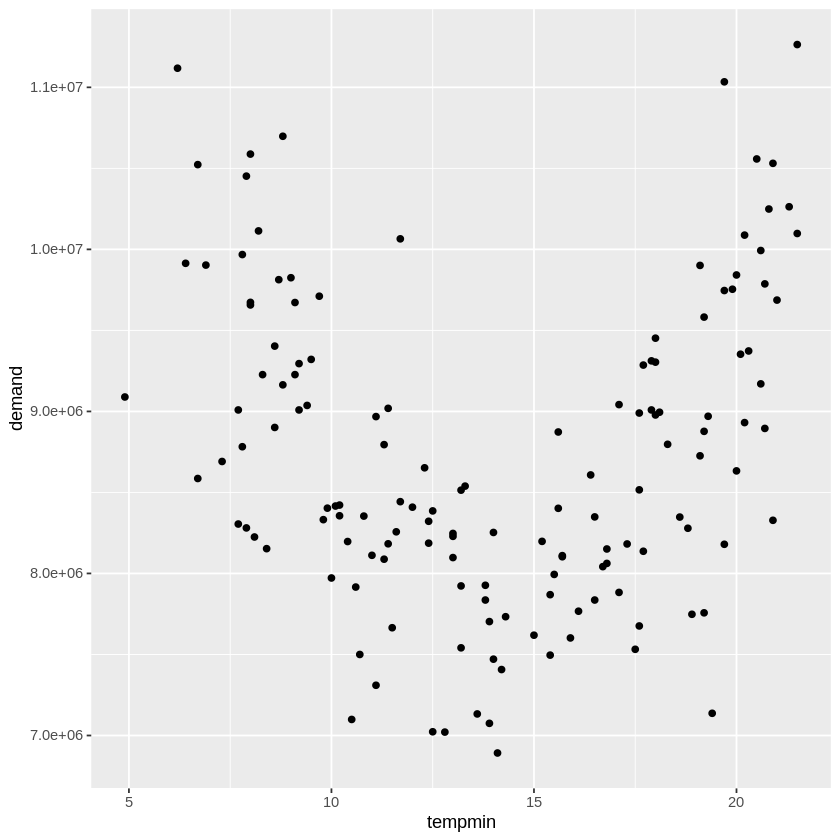

In [321]:
# tempmin plot
scatter_plot('demand', 'tempmin')

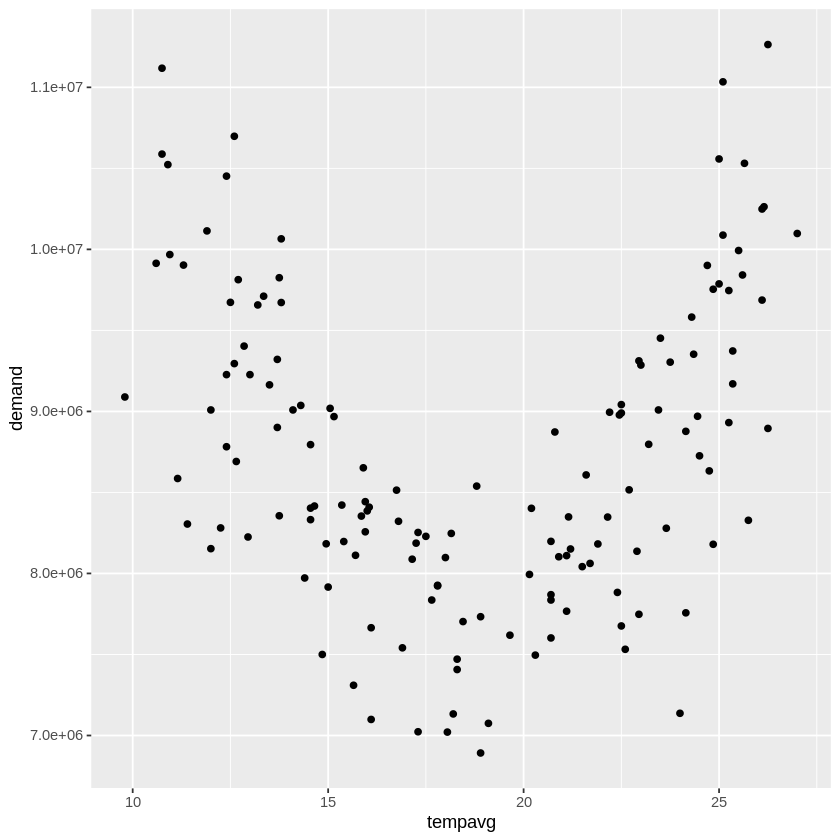

In [322]:
data$tempavg = (data$tempmax + data$tempmin) / 2
scatter_plot('demand', 'tempavg')

In [323]:
data$tempavg2 = data$tempavg^2
predictors <- c('t', 'tempavg2', 'tempavg')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1195668  -275175     4575   275692   991090 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19915581.7   640588.9   31.09   <2e-16 ***
t              11601.4      883.4   13.13   <2e-16 ***
tempavg2       37271.9     1917.6   19.44   <2e-16 ***
tempavg     -1386385.7    71930.7  -19.27   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 440400 on 140 degrees of freedom
Multiple R-squared:  0.7918,	Adjusted R-squared:  0.7874 
F-statistic: 177.5 on 3 and 140 DF,  p-value: < 2.2e-16



In [324]:
reset_test(model)


	RESET test

data:  model
RESET = 2.5455, df1 = 1, df2 = 139, p-value = 0.1129


[1] "The p-value of the Breusch-Pagan test is 0.526693836715556"


 lag Autocorrelation D-W Statistic p-value
   1       0.2068743      1.550872   0.008
 Alternative hypothesis: rho != 0


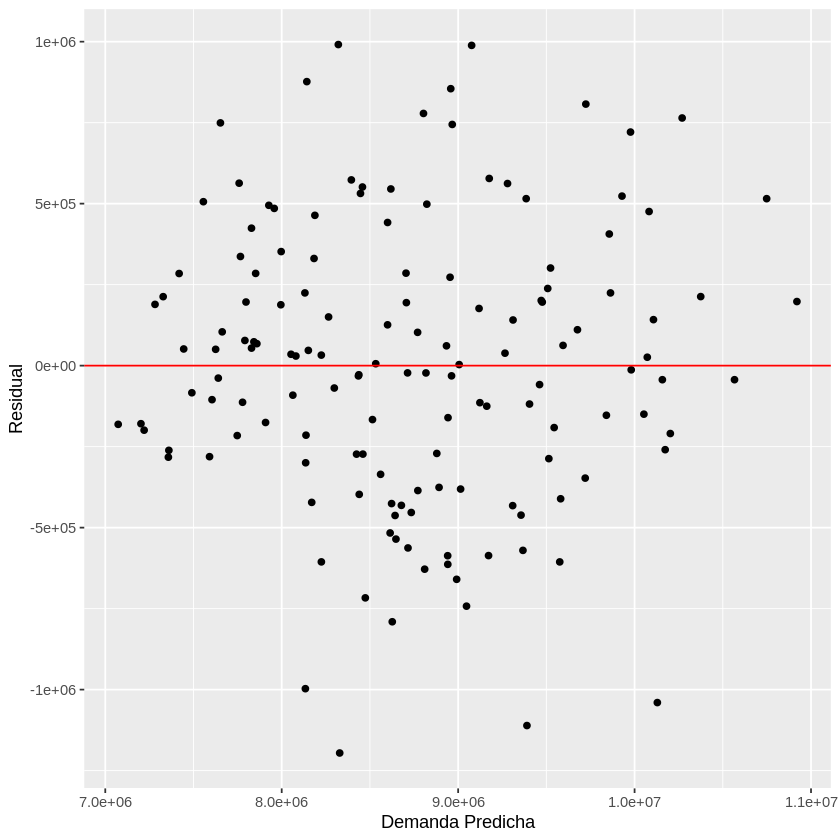

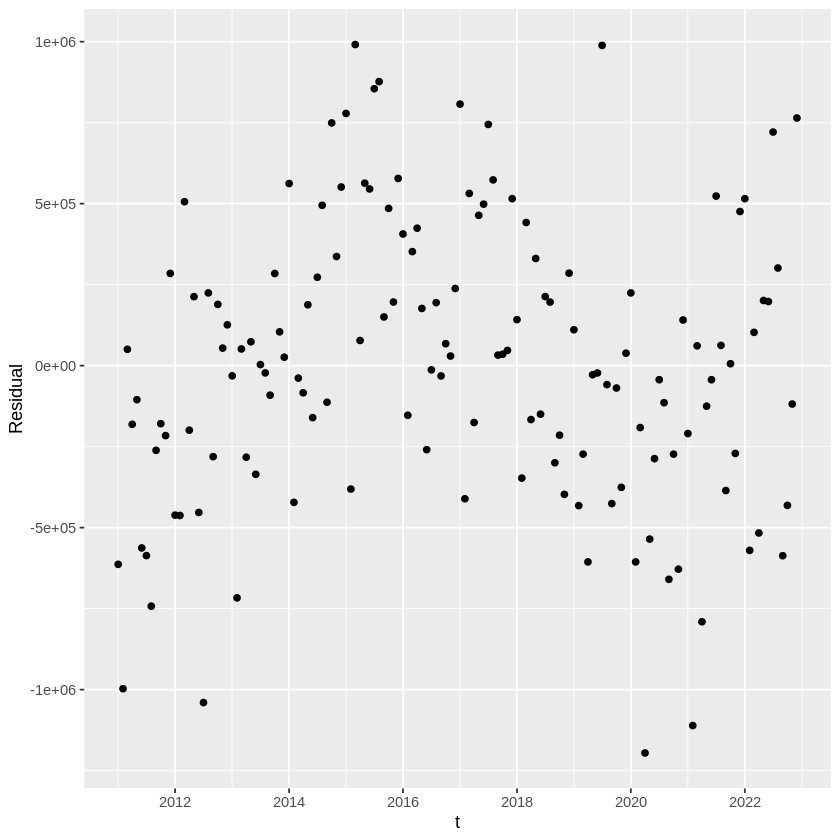

In [325]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.99274, p-value = 0.6771



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


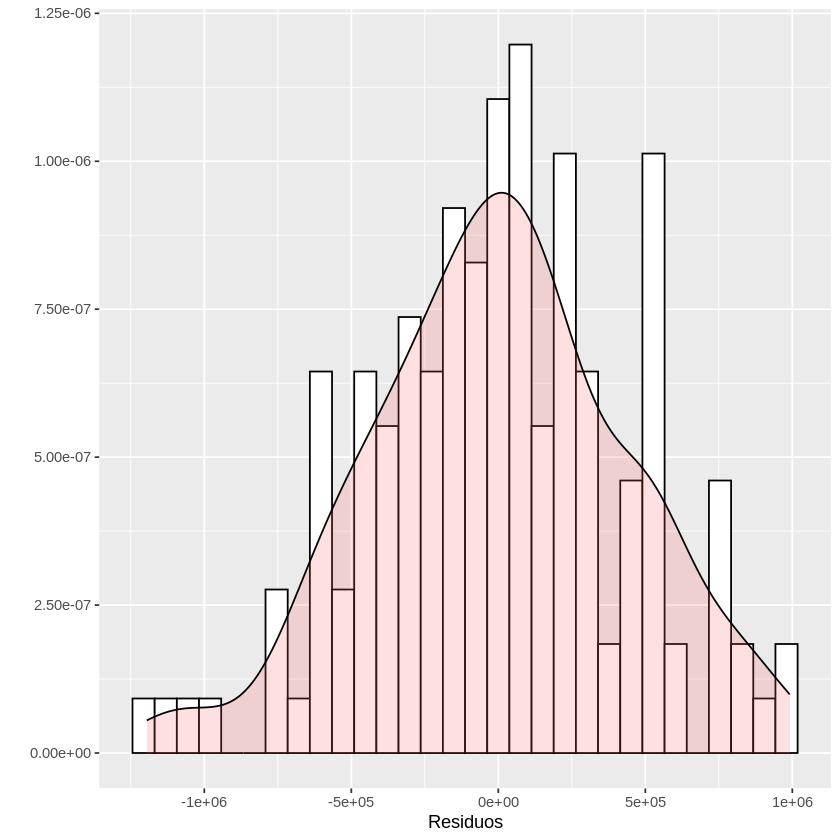

In [326]:
# Plotting the distribution of the residuals
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


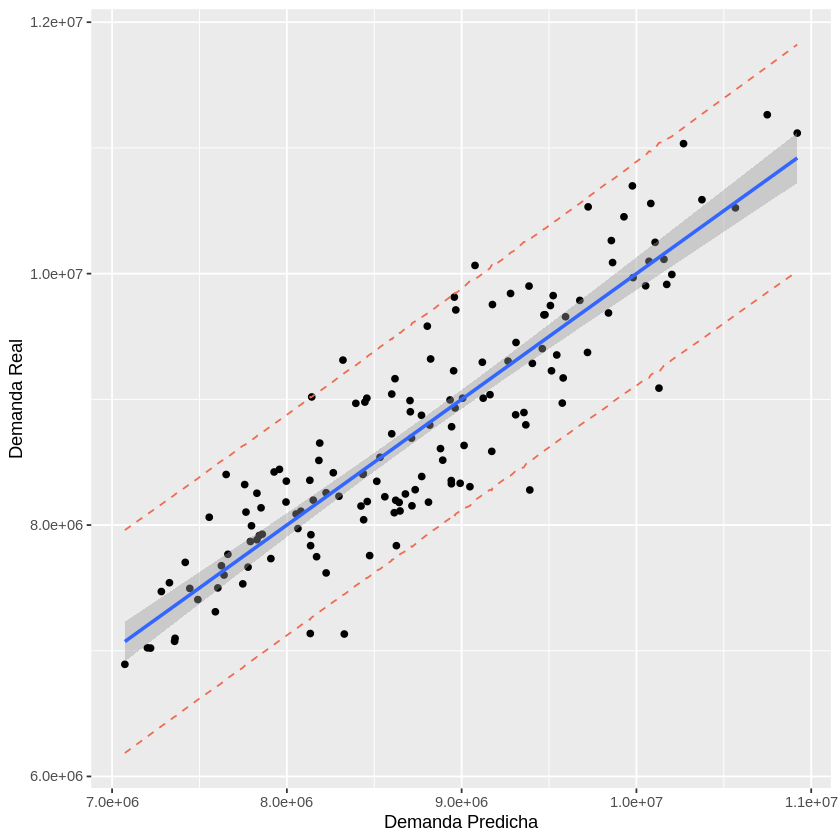

In [327]:
pred_intervals('demand', model, predictors, data)

In [377]:
subs_model <- build_subs_model(model, data)


Call:
lm(formula = true_subs ~ est_subs, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-313146  -89919  -10550   93970  332926 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -1.278e+05  3.235e+04   -3.95 0.000123 ***
est_subs     1.099e+00  2.118e-02   51.88  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 134400 on 142 degrees of freedom
Multiple R-squared:  0.9499,	Adjusted R-squared:  0.9495 
F-statistic:  2692 on 1 and 142 DF,  p-value: < 2.2e-16



[1] "The MAE for the subsidies estimator is 57650300.8618407"
[1] "The MAPE for the subsidies estimator is 3.93738451321834"
[1] "Max error is 212031334.00593"
[1] "Min error is -303612407.875109"
[1] "Max percentage error is 10.6431440527769"
[1] "Min percentage error is -16.7624844309718"


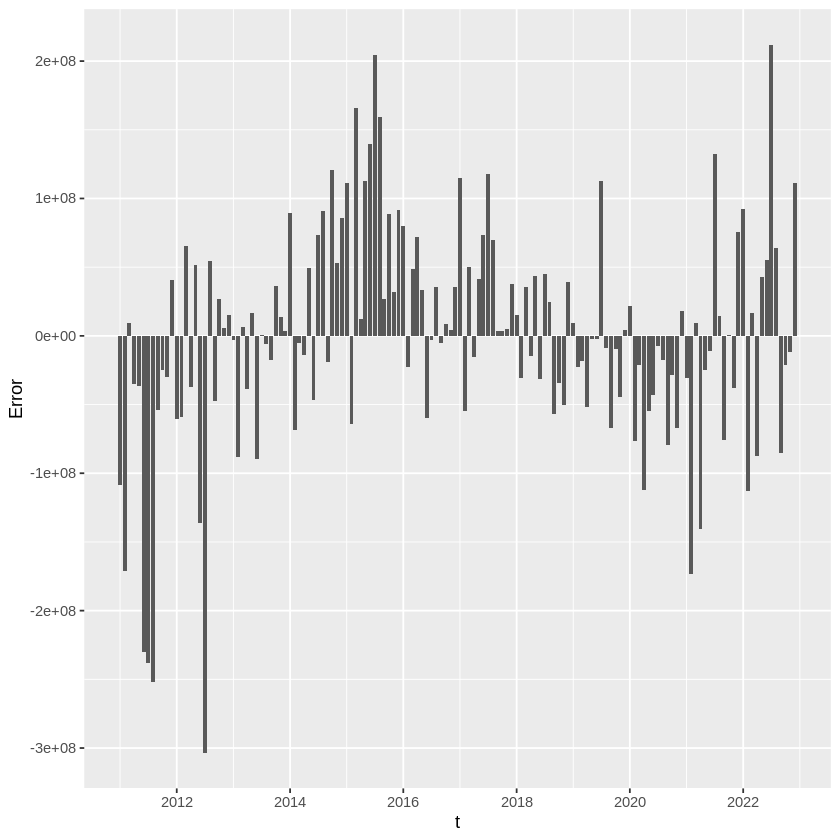

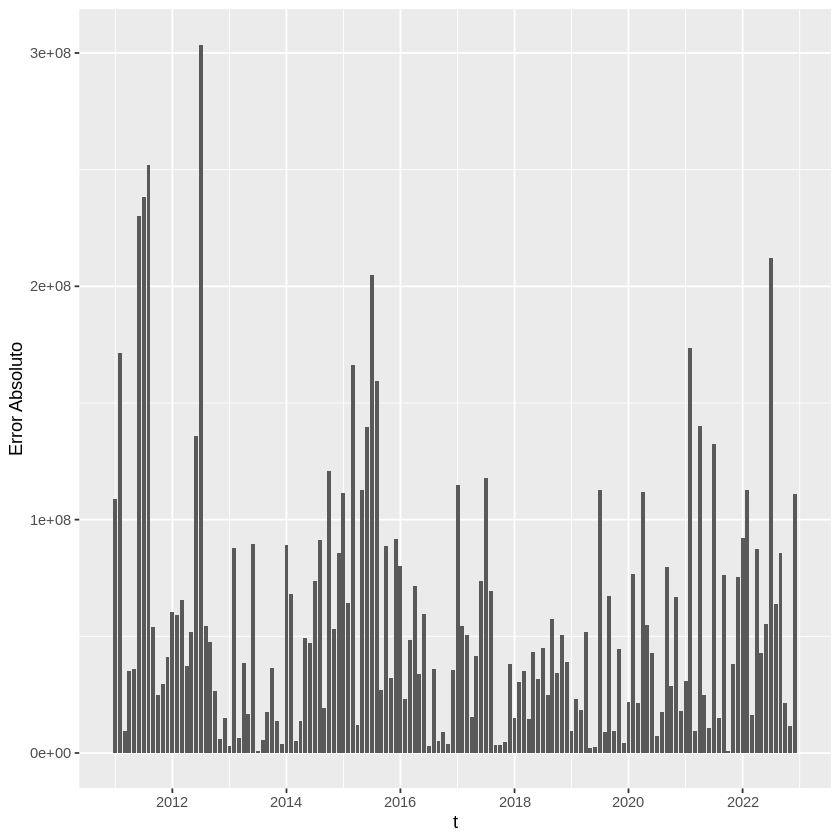

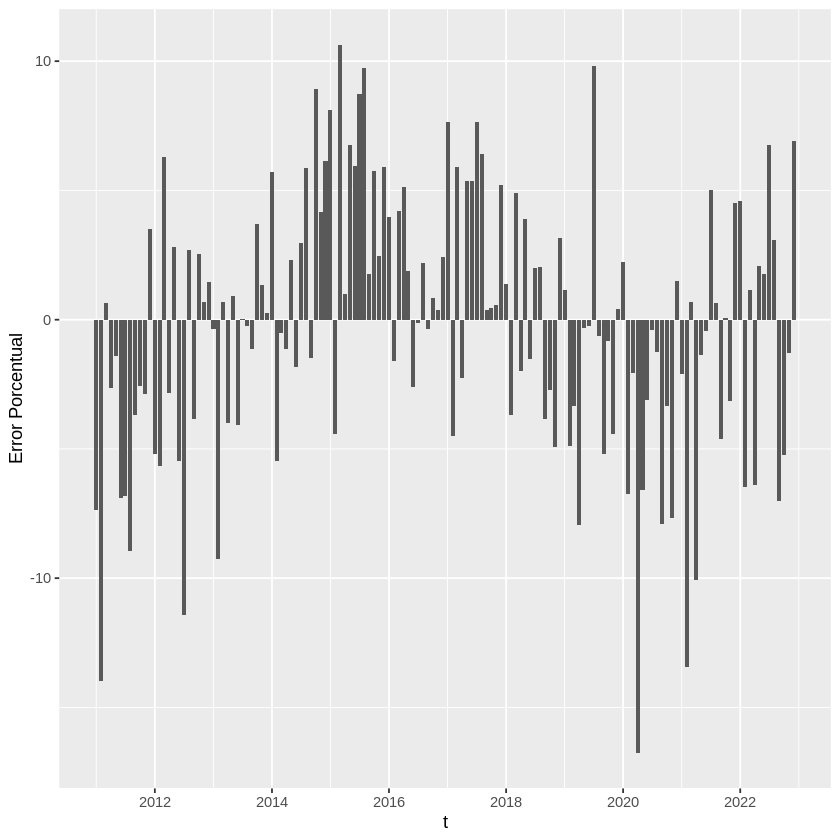

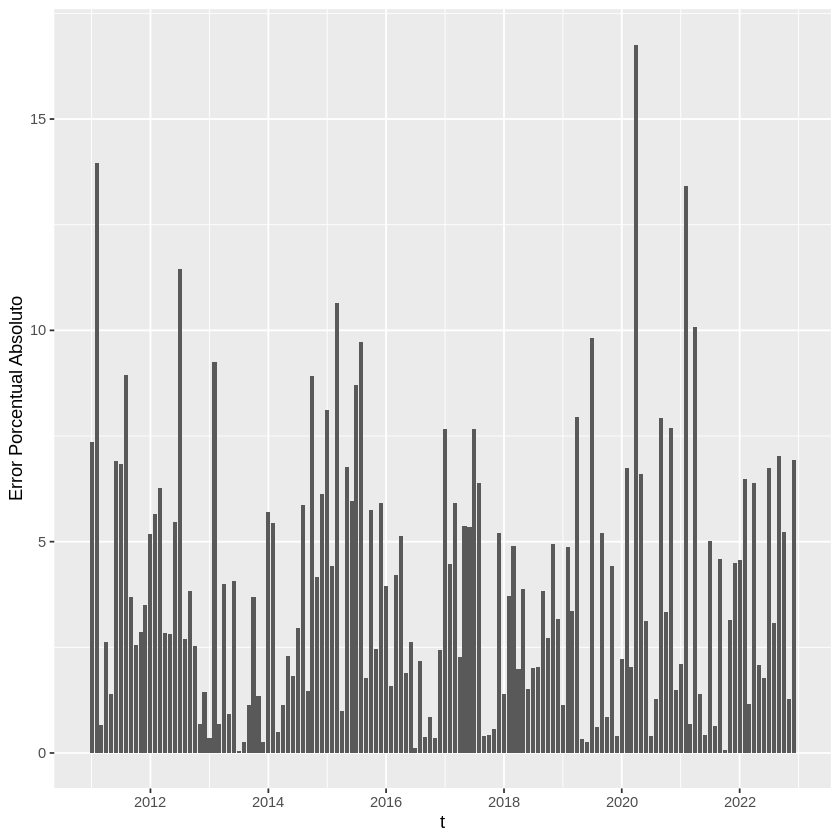

In [328]:
calc_plot_subs_errors(model, data)

## Model 3: Adding Inflation Adjusted Electricity Price

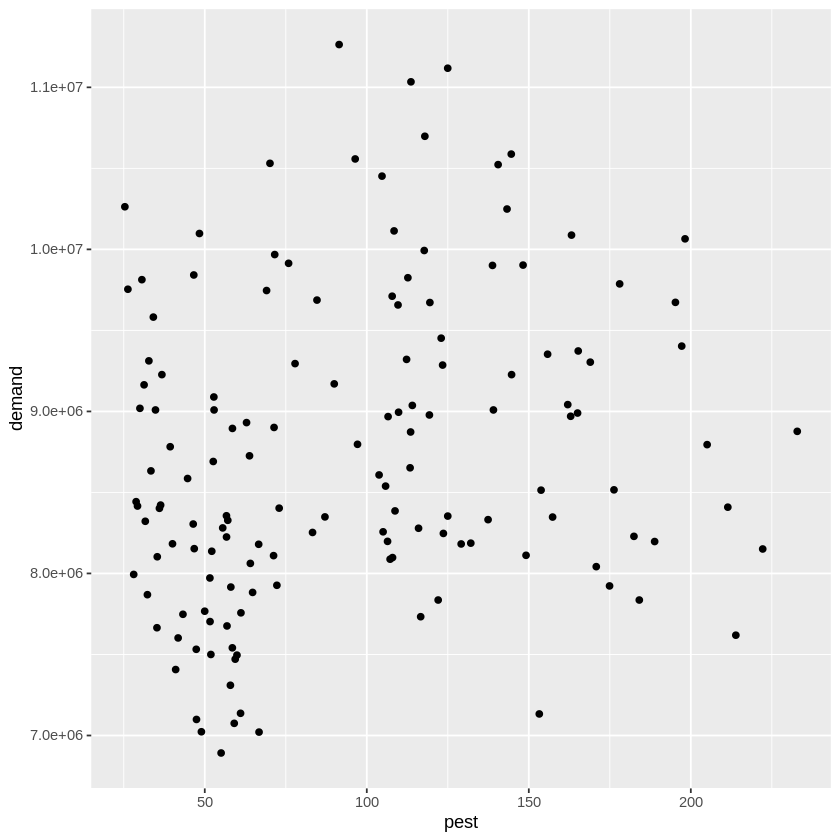

In [329]:
scatter_plot('demand', 'pest')

In [330]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1182655  -233357   -10726   273962  1231080 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 19904182     618770  32.167  < 2e-16 ***
t              14294       1176  12.150  < 2e-16 ***
tempavg2       36952       1855  19.923  < 2e-16 ***
tempavg     -1373830      69582 -19.744  < 2e-16 ***
pest           -3132        942  -3.324  0.00113 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 425400 on 139 degrees of freedom
Multiple R-squared:  0.8072,	Adjusted R-squared:  0.8016 
F-statistic: 145.5 on 4 and 139 DF,  p-value: < 2.2e-16



In [331]:
reset_test(model)


	RESET test

data:  model
RESET = 2.4136, df1 = 1, df2 = 138, p-value = 0.1226


[1] "The p-value of the Breusch-Pagan test is 0.725374062156207"


 lag Autocorrelation D-W Statistic p-value
   1         0.16186      1.649013   0.016
 Alternative hypothesis: rho != 0


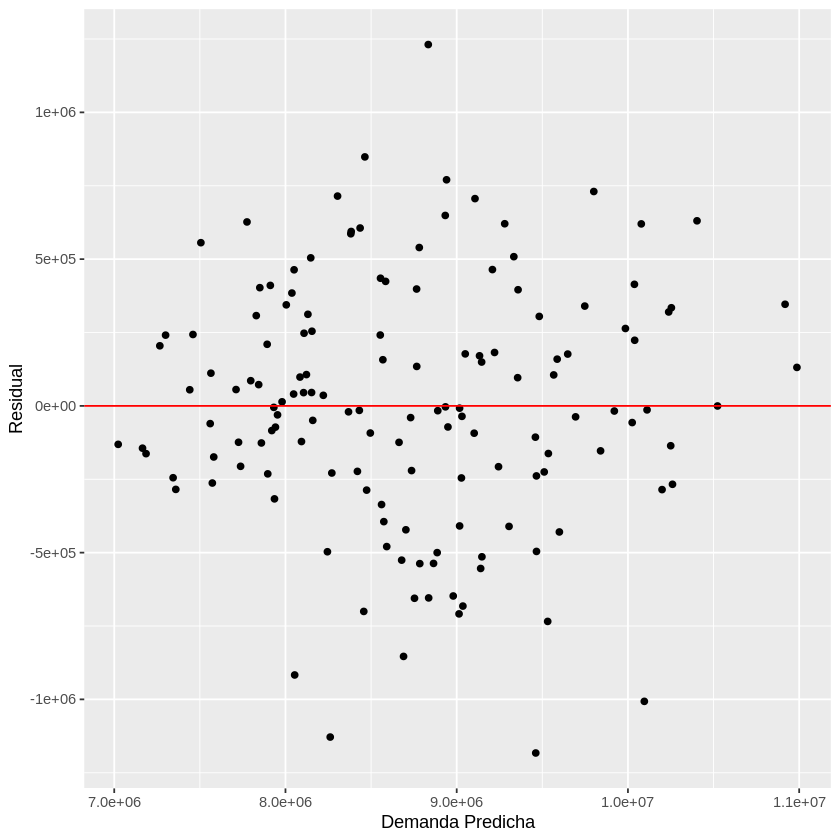

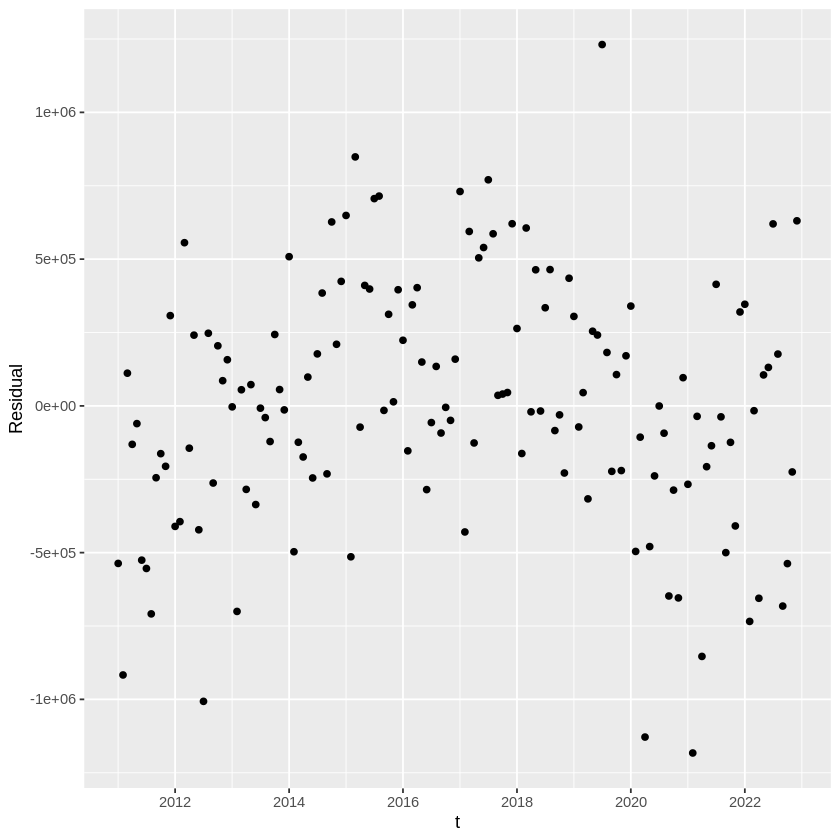

In [332]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.9927, p-value = 0.6734



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


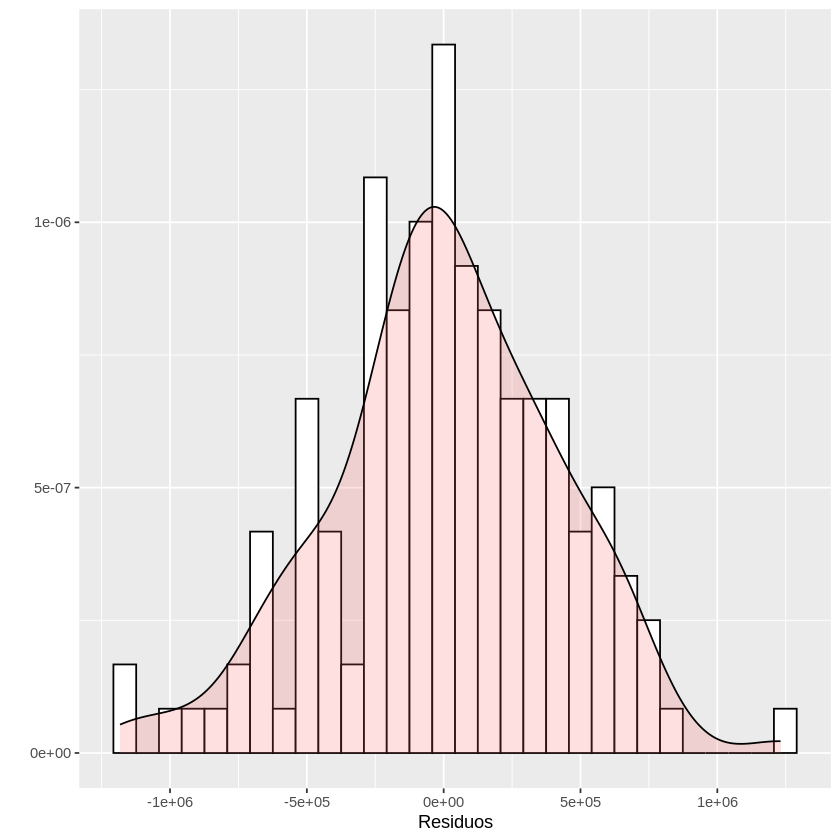

In [333]:
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


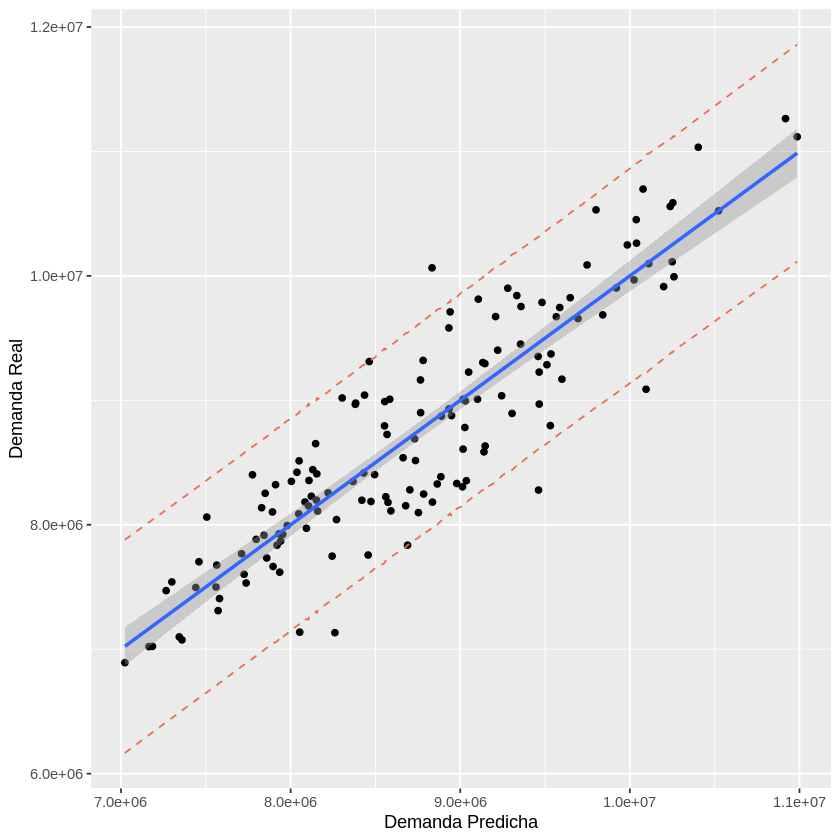

In [334]:
pred_intervals('demand', model, predictors, data)

### Model 4: Taking into Account Wages

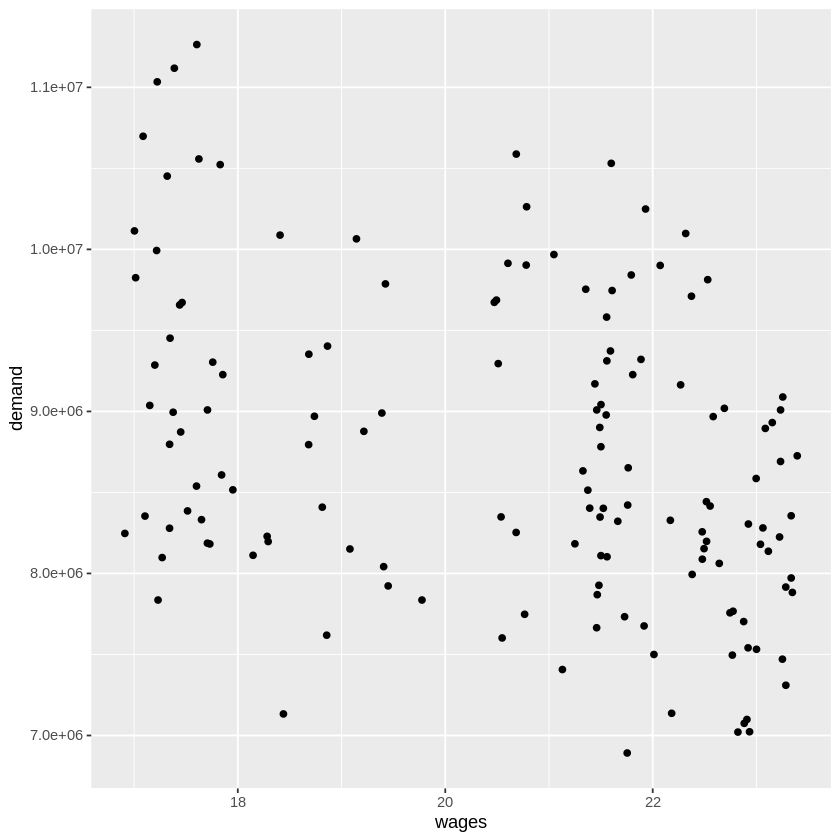

In [335]:
scatter_plot('demand', 'wages')

In [336]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest', 'wages')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-1067691  -234403   -25095   261736  1254223 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15527165.9  1039988.2  14.930  < 2e-16 ***
t              22834.5     2013.8  11.339  < 2e-16 ***
tempavg2       36984.5     1710.9  21.616  < 2e-16 ***
tempavg     -1372901.2    64187.3 -21.389  < 2e-16 ***
pest           -3235.9      869.2  -3.723 0.000286 ***
wages         181561.1    36061.2   5.035 1.47e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 392400 on 138 degrees of freedom
Multiple R-squared:  0.8371,	Adjusted R-squared:  0.8312 
F-statistic: 141.8 on 5 and 138 DF,  p-value: < 2.2e-16



In [337]:
reset_test(model)


	RESET test

data:  model
RESET = 0.28549, df1 = 1, df2 = 137, p-value = 0.594


[1] "The p-value of the Breusch-Pagan test is 0.71606338033049"


 lag Autocorrelation D-W Statistic p-value
   1      0.03466243       1.91011   0.362
 Alternative hypothesis: rho != 0


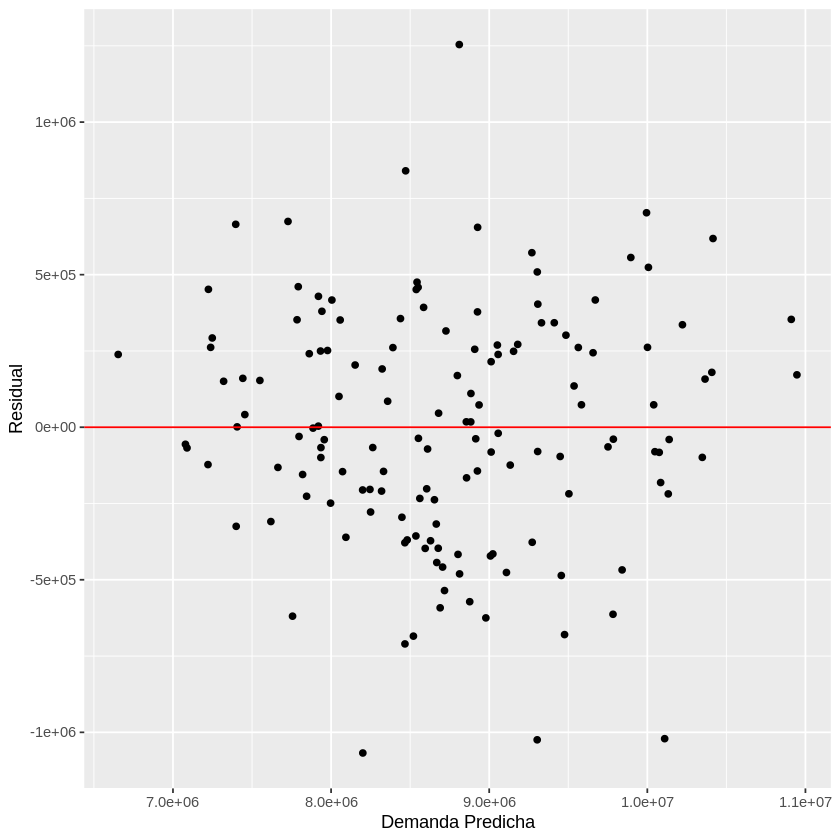

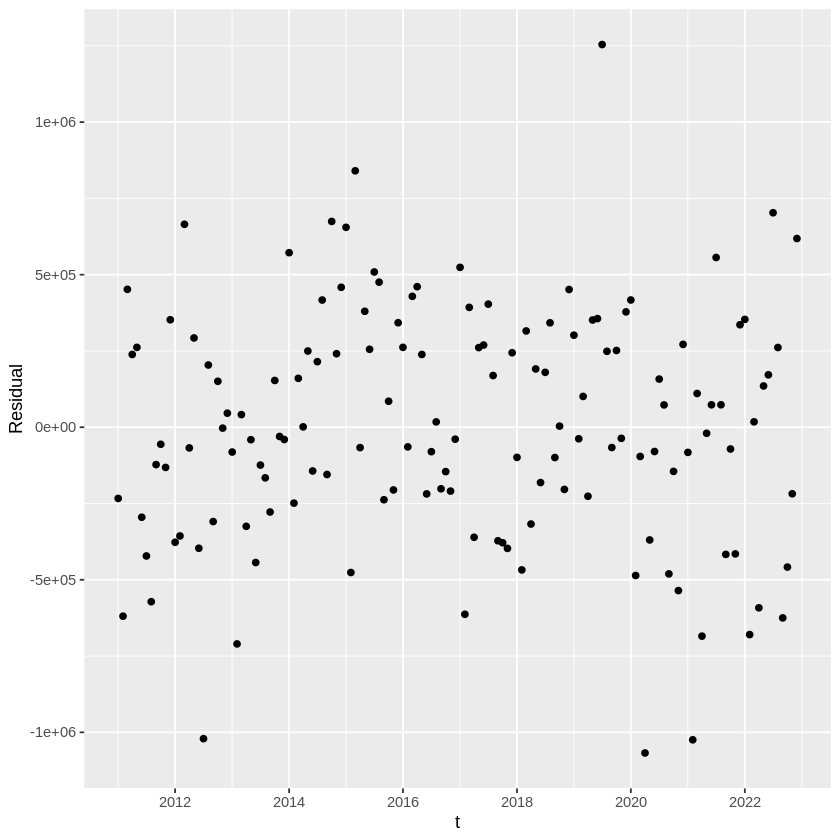

In [338]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.99082, p-value = 0.4718



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


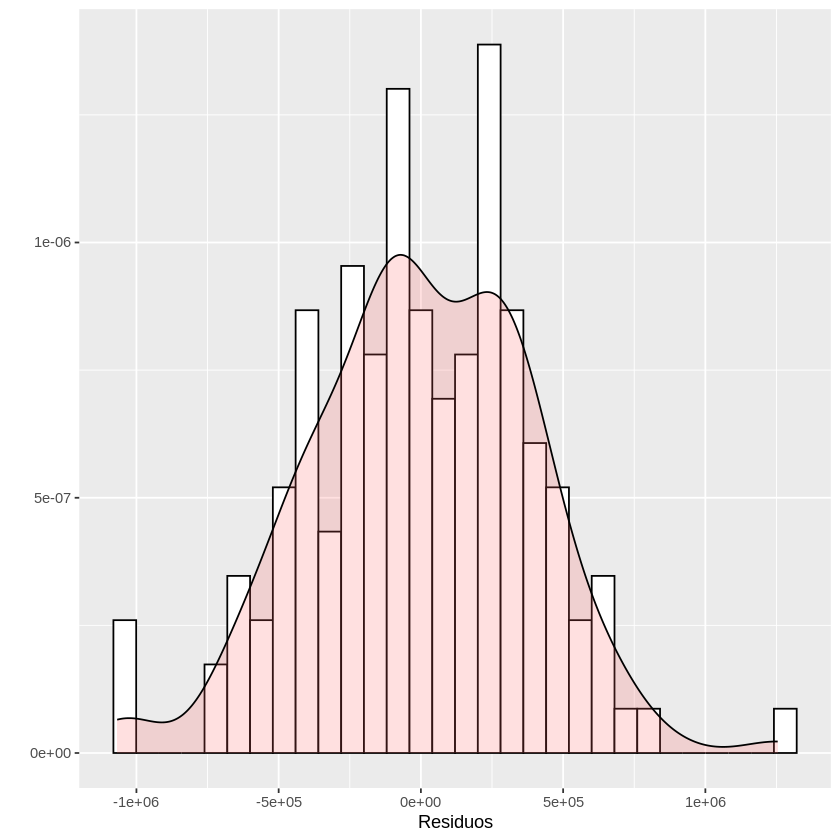

In [339]:
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


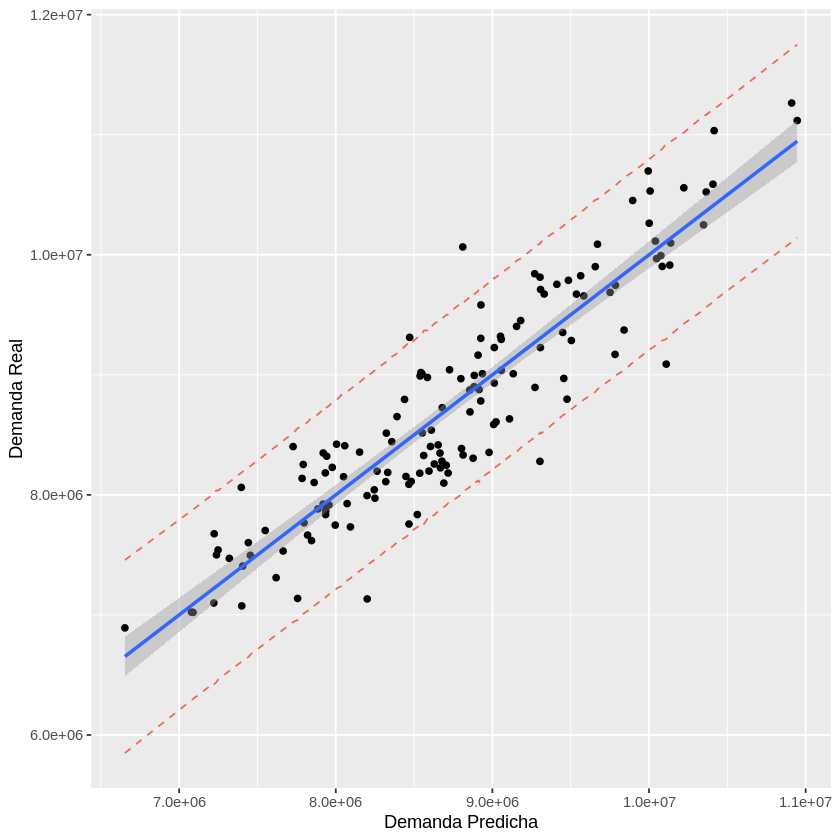

In [340]:
pred_intervals('demand', model, predictors, data)

[1] "The MAE for the subsidies estimator is 50977873.8172881"
[1] "The MAPE for the subsidies estimator is 3.54043023144711"
[1] "Max error is 206732431.876136"
[1] "Min error is -297992376.436153"
[1] "Max percentage error is 12.4612365552133"
[1] "Min percentage error is -14.9683350497634"


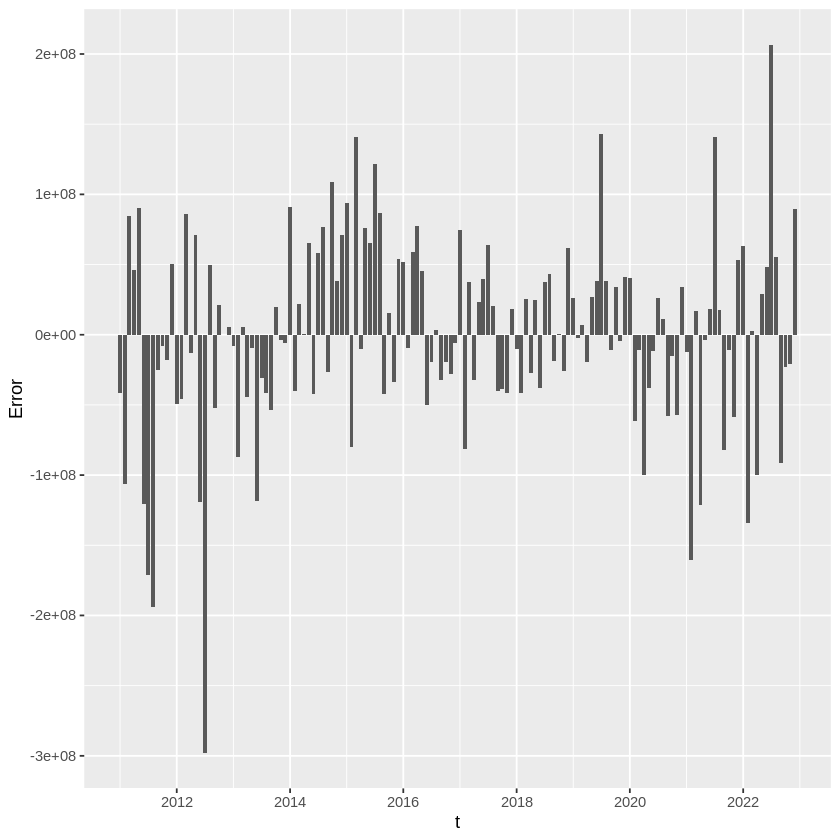

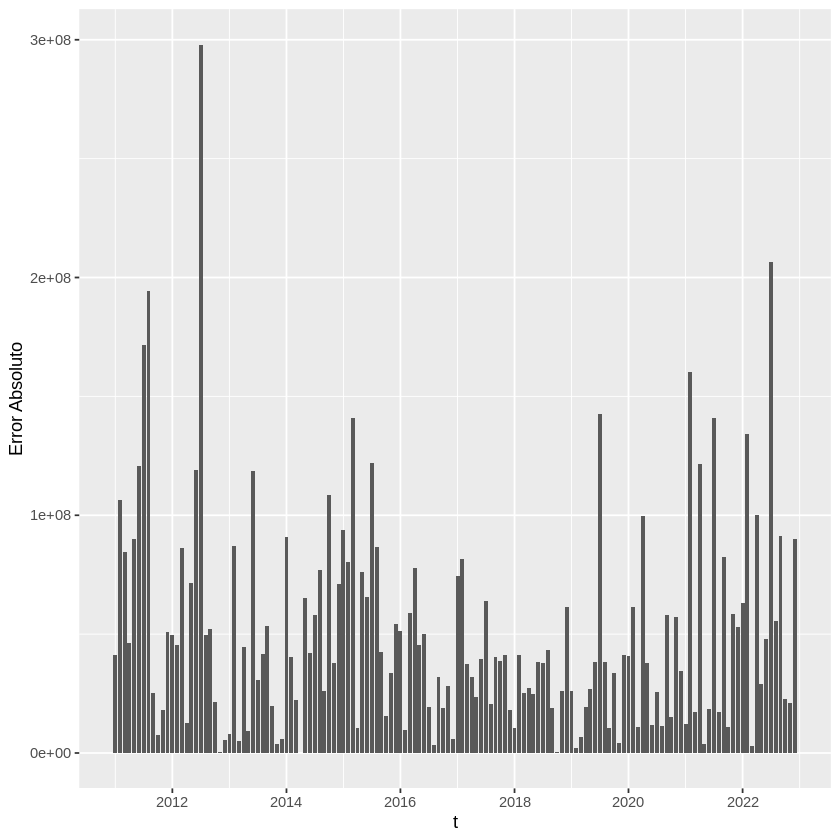

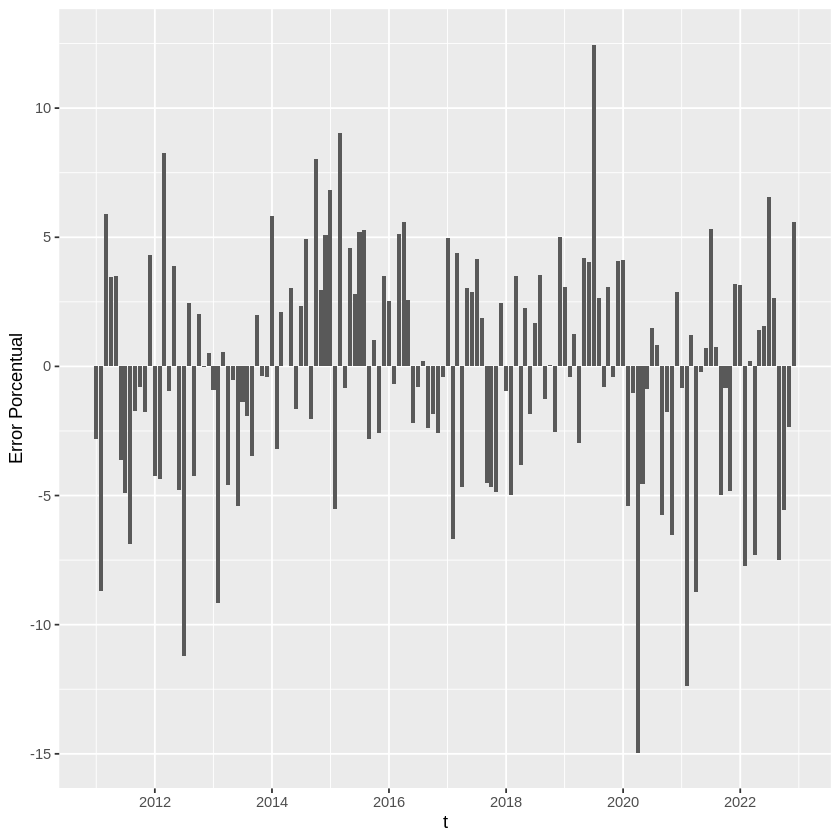

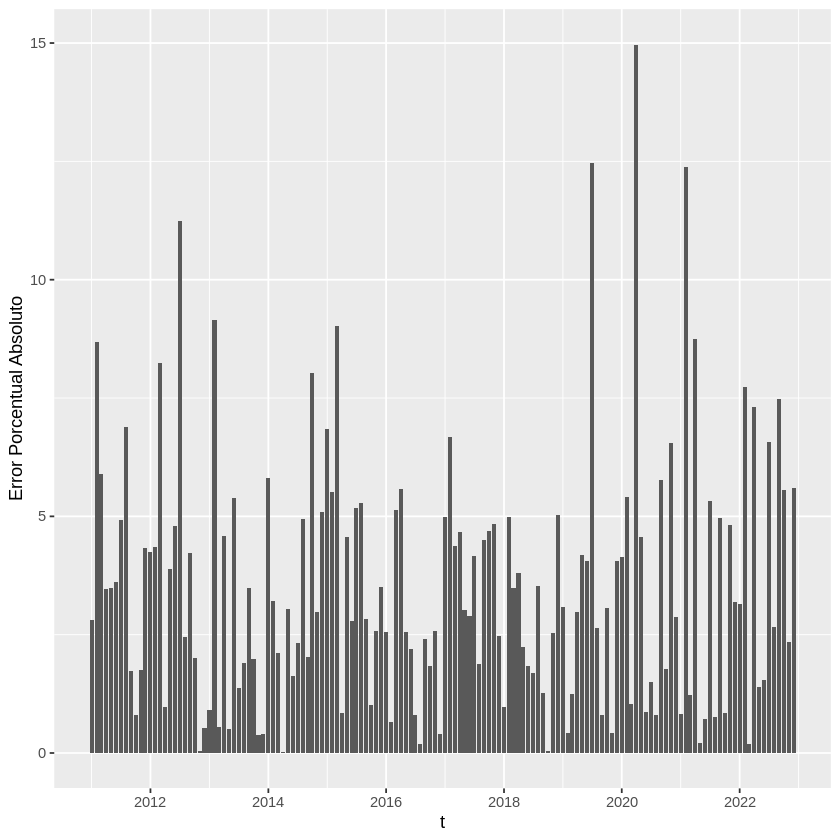

In [341]:
calc_plot_subs_errors(model, data)

### Model 5: Taking into account economic activity


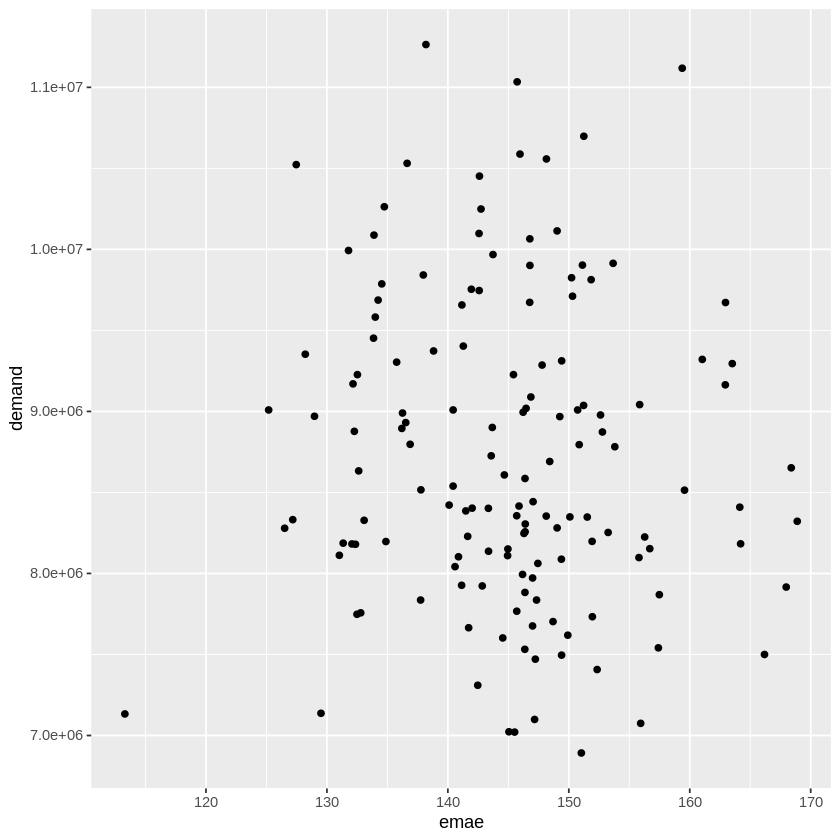

In [342]:
scatter_plot('demand', 'emae')

In [343]:
predictors <- c('t', 'tempavg2', 'tempavg', 'pest', 'wages', 'emae')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-987628 -220103     430  254690 1230343 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) 14412487.2  1020543.3  14.122  < 2e-16 ***
t              21224.6     1945.2  10.911  < 2e-16 ***
tempavg2       38633.9     1667.7  23.166  < 2e-16 ***
tempavg     -1421477.4    61873.9 -22.974  < 2e-16 ***
pest           -2788.3      829.7  -3.360 0.001008 ** 
wages         140898.4    35518.7   3.967 0.000117 ***
emae           16012.9     3875.3   4.132 6.22e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 371300 on 137 degrees of freedom
Multiple R-squared:  0.8551,	Adjusted R-squared:  0.8488 
F-statistic: 134.8 on 6 and 137 DF,  p-value: < 2.2e-16



In [344]:
reset_test(model)


	RESET test

data:  model
RESET = 0.11401, df1 = 1, df2 = 136, p-value = 0.7361


[1] "The p-value of the Breusch-Pagan test is 0.597859198392176"


 lag Autocorrelation D-W Statistic p-value
   1      0.08535328      1.815599   0.142
 Alternative hypothesis: rho != 0


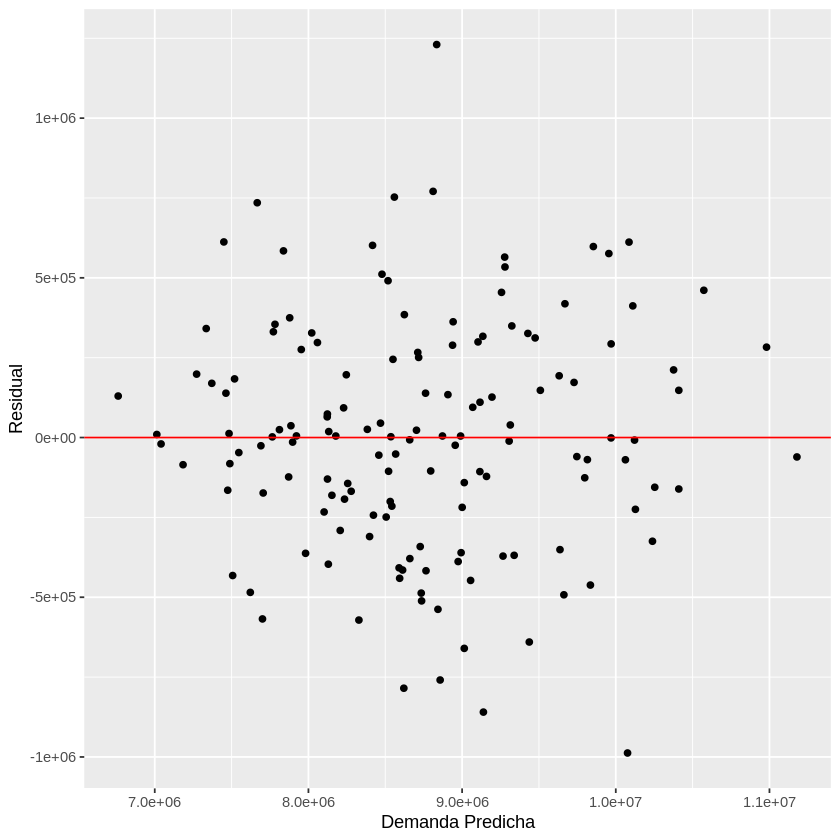

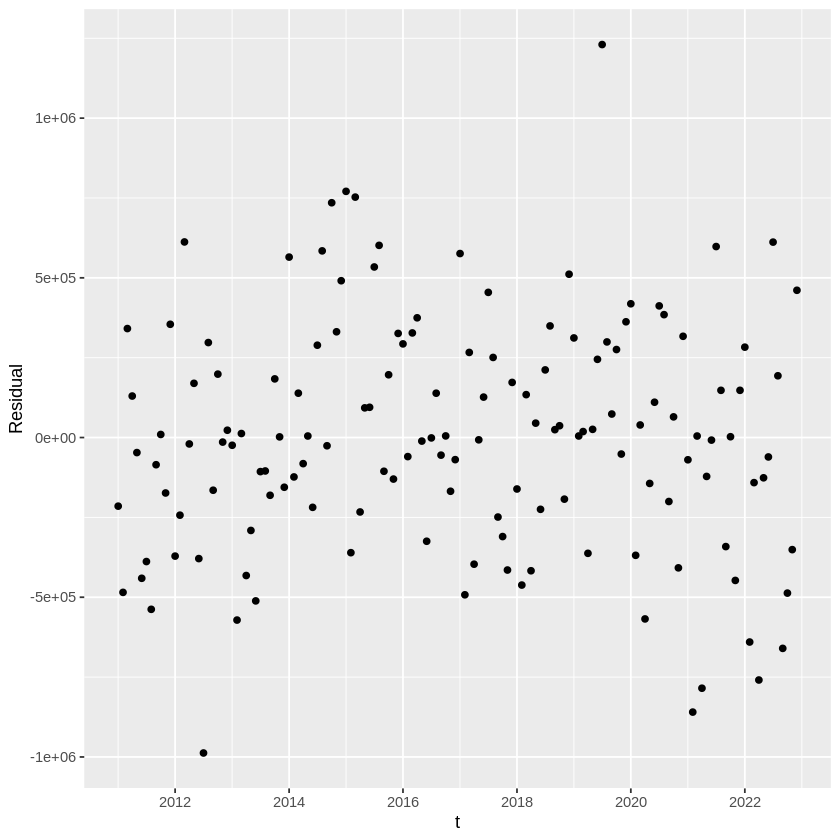

In [345]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.99397, p-value = 0.811



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


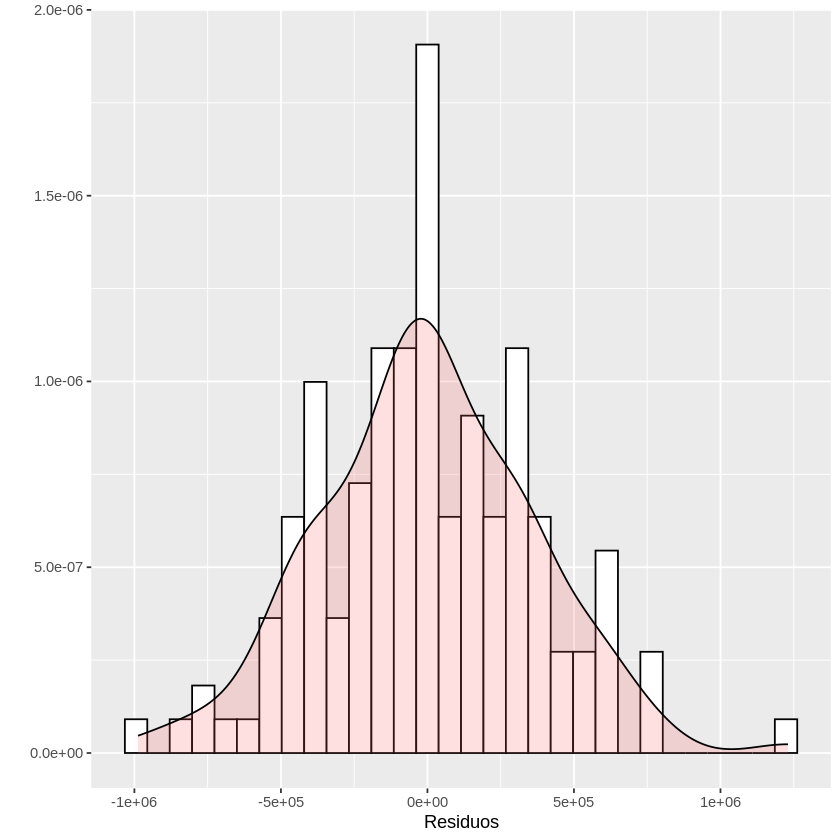

In [346]:
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


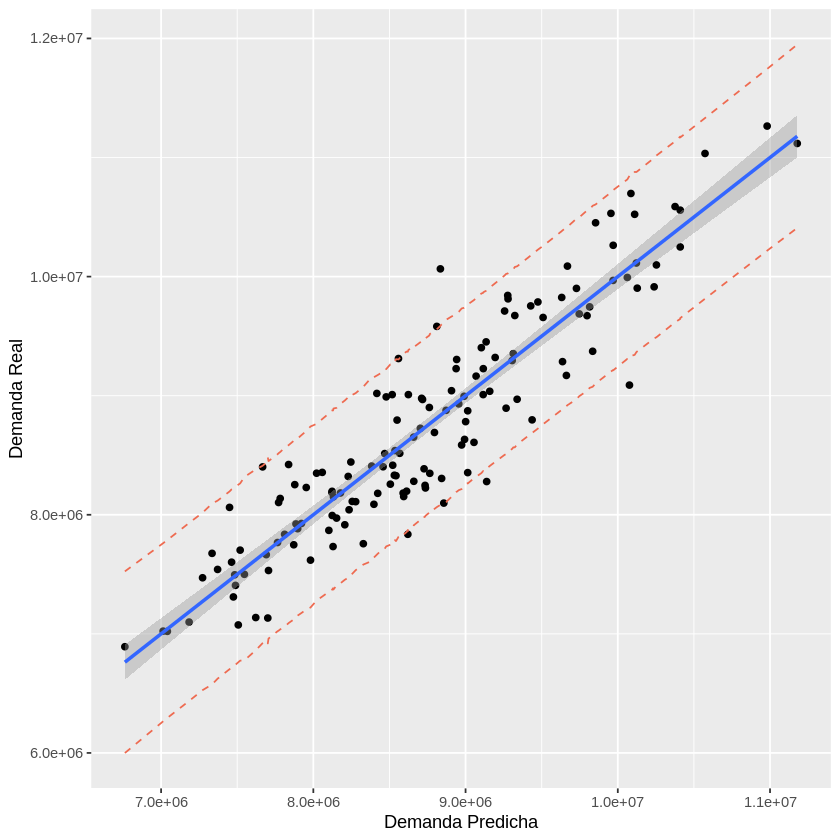

In [347]:
pred_intervals('demand', model, predictors, data)

[1] "The MAE for the subsidies estimator is 47246390.1135301"
[1] "The MAPE for the subsidies estimator is 3.20774385619136"
[1] "Max error is 179927660.19198"
[1] "Min error is -288316843.492873"
[1] "Max percentage error is 12.2239709232131"
[1] "Min percentage error is -10.8661901626691"


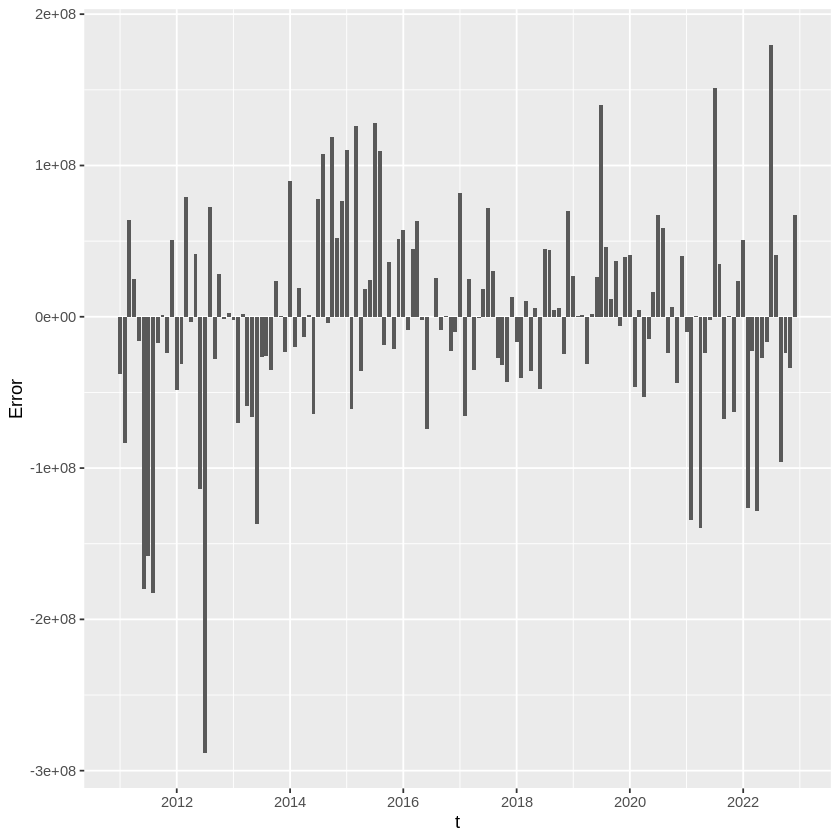

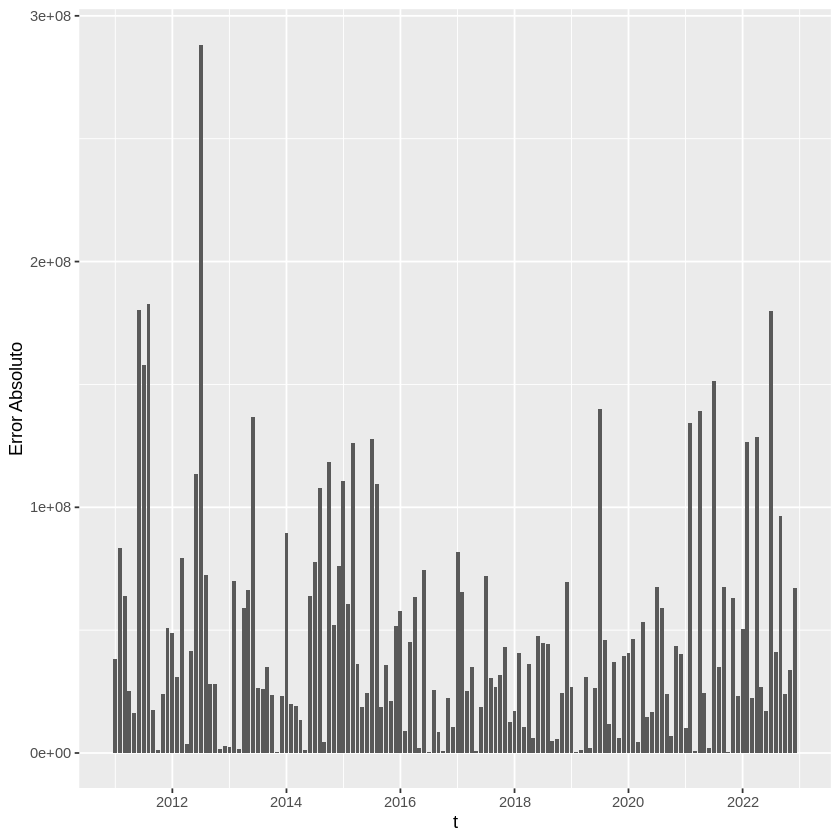

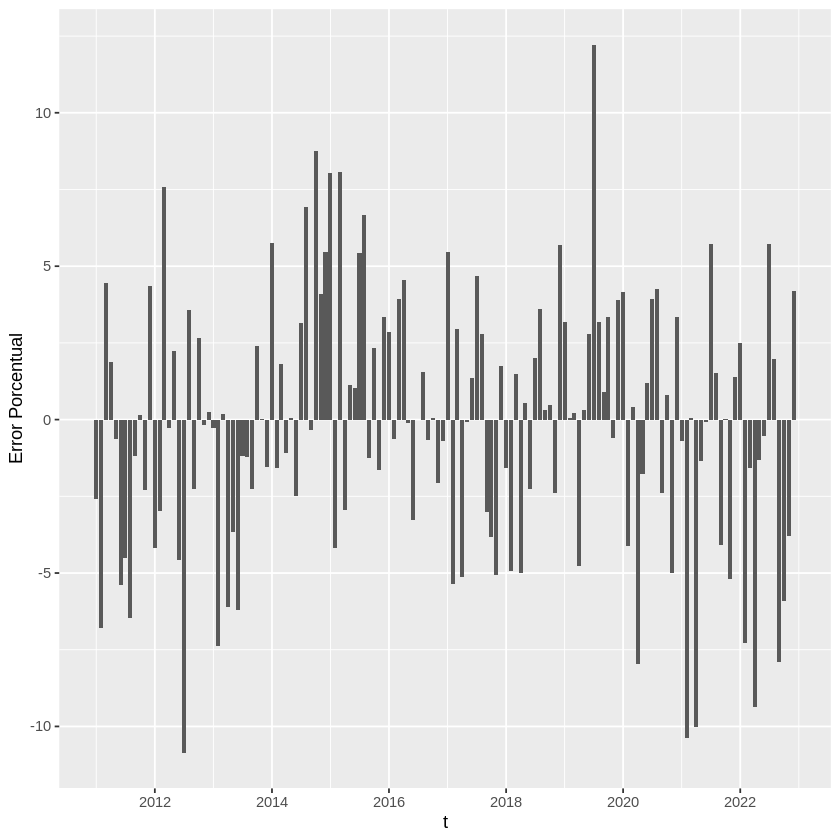

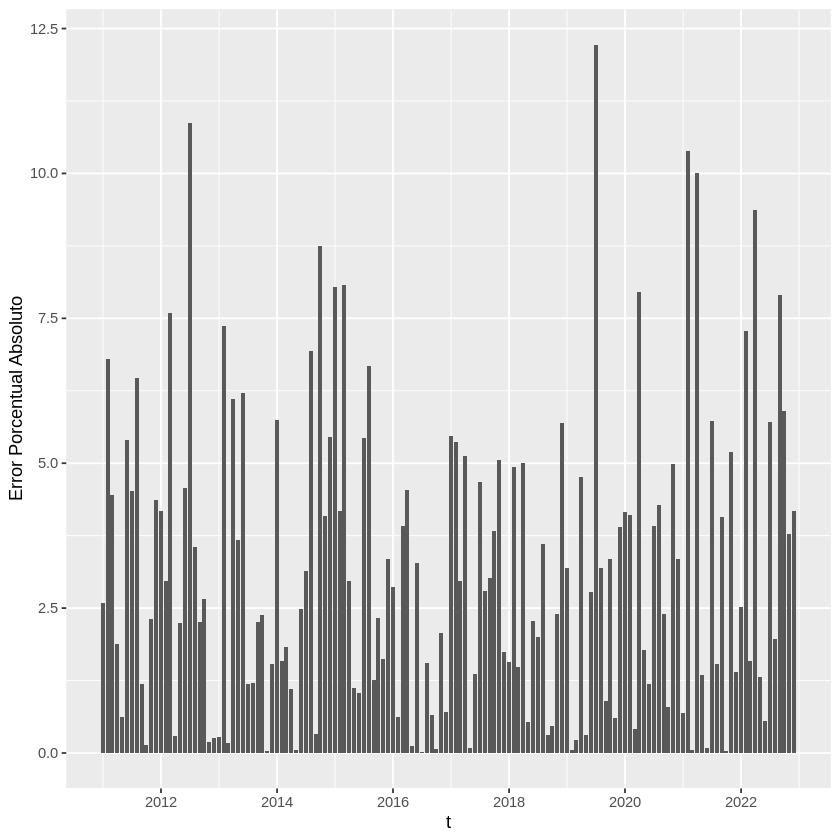

In [348]:
calc_plot_subs_errors(model, data)

### Model 6: Trying log(pest)

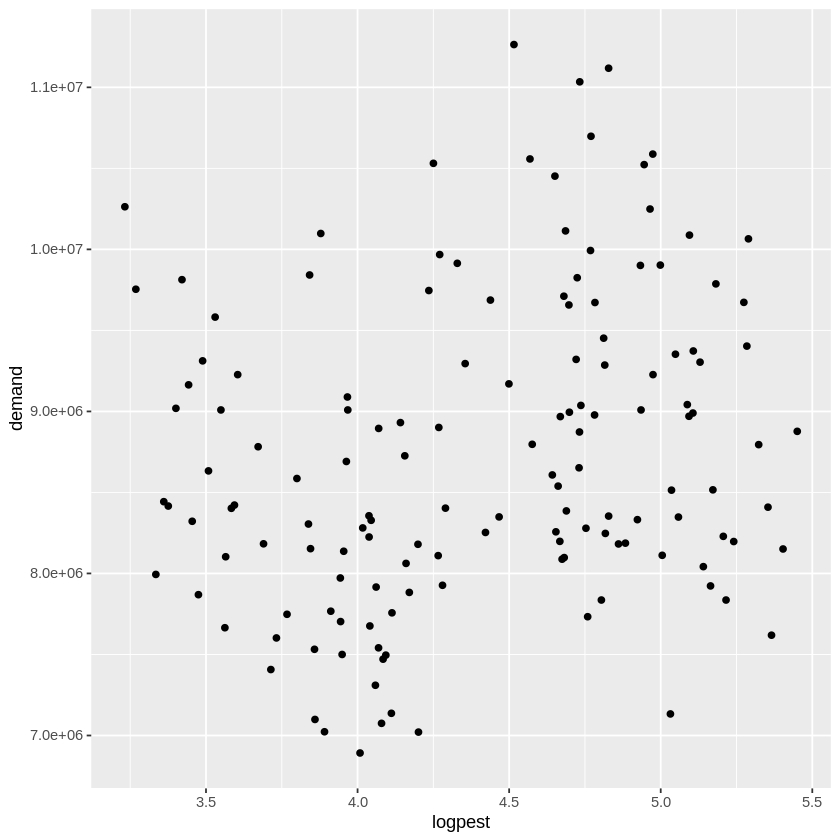

In [349]:
data$logpest = log(data$pest)
scatter_plot('demand', 'logpest')

In [350]:
predictors <- c('t', 'tempavg2', 'tempavg', 'logpest', 'wages', 'emae')
formula <- build_formula('demand', predictors)
model <- build_model(formula, data)


Call:
lm(formula = form_str, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-972764 -215257    2676  227241 1211955 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 15541200    1025722  15.151  < 2e-16 ***
t              22256       1914  11.628  < 2e-16 ***
tempavg2       38758       1617  23.968  < 2e-16 ***
tempavg     -1426205      60004 -23.769  < 2e-16 ***
logpest      -332004      74212  -4.474 1.60e-05 ***
wages         143929      34532   4.168 5.41e-05 ***
emae           15812       3758   4.208 4.64e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 360900 on 137 degrees of freedom
Multiple R-squared:  0.8632,	Adjusted R-squared:  0.8572 
F-statistic: 144.1 on 6 and 137 DF,  p-value: < 2.2e-16



In [351]:
reset_test(model)


	RESET test

data:  model
RESET = 0.02104, df1 = 1, df2 = 136, p-value = 0.8849


[1] "The p-value of the Breusch-Pagan test is 0.62064596800329"


 lag Autocorrelation D-W Statistic p-value
   1      0.03181734      1.923242   0.364
 Alternative hypothesis: rho != 0


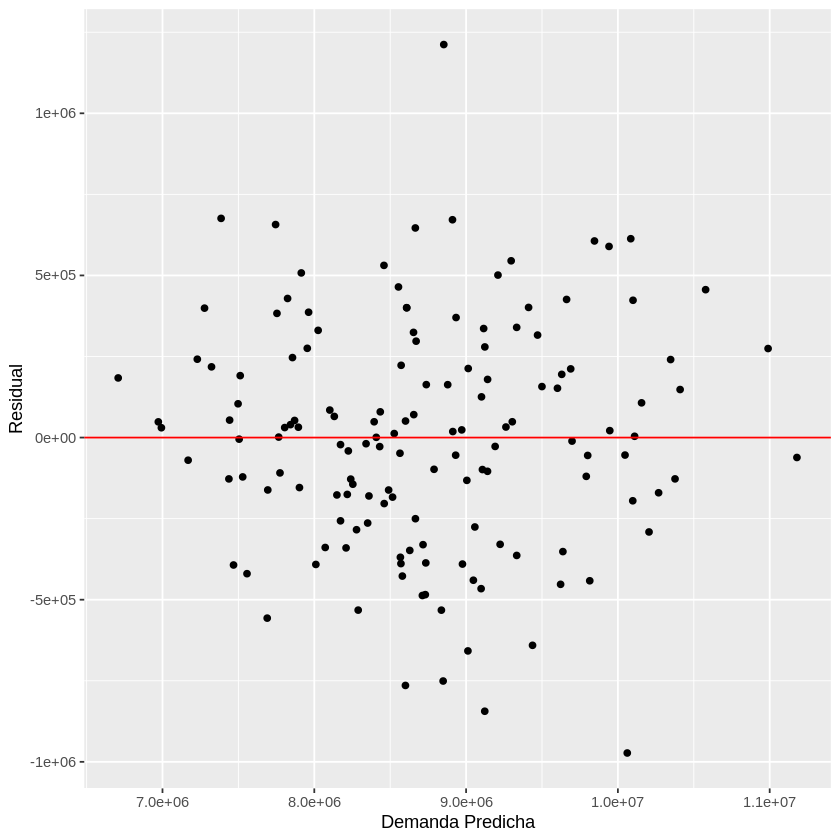

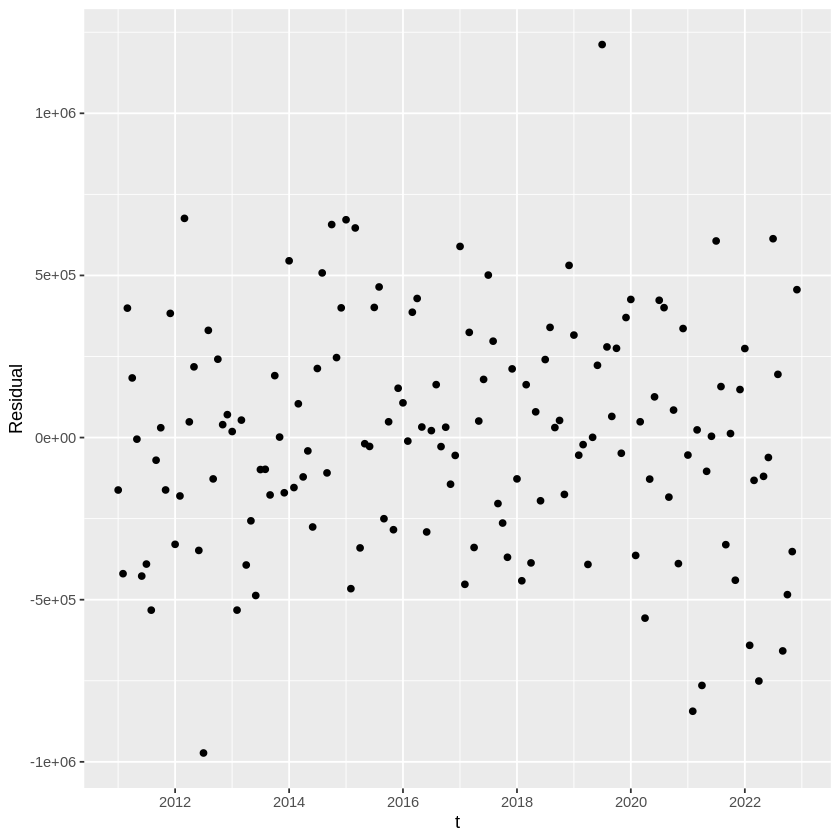

In [352]:
heterosk_test(model)
autocorr_test(model, data)


	Shapiro-Wilk normality test

data:  model$residuals
W = 0.99327, p-value = 0.7361



`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


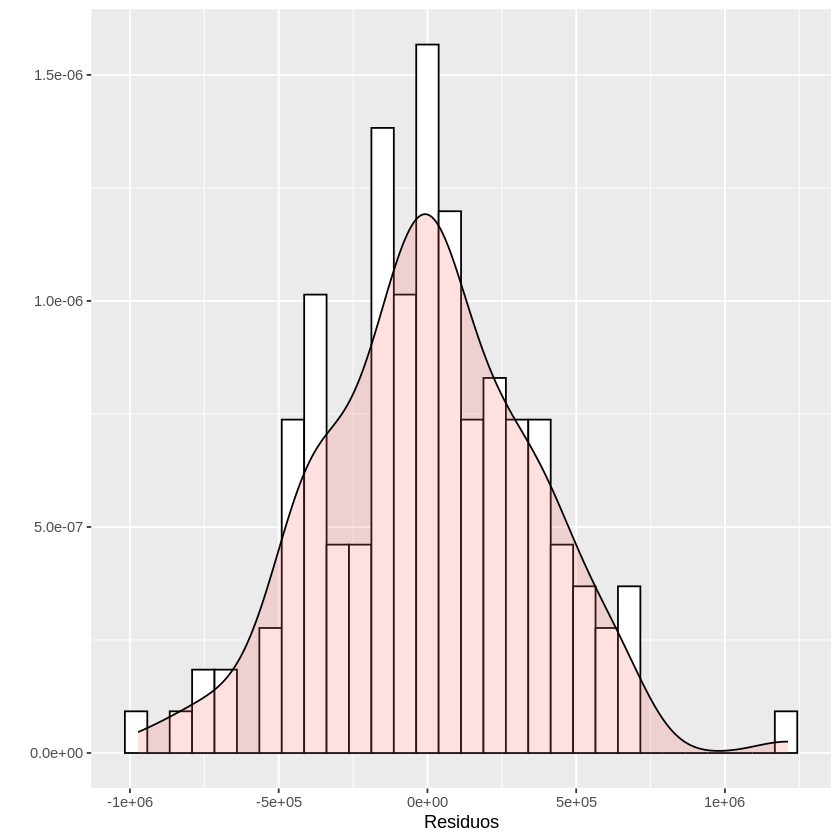

In [353]:
res_dist(model)

`geom_smooth()` using formula = 'y ~ x'


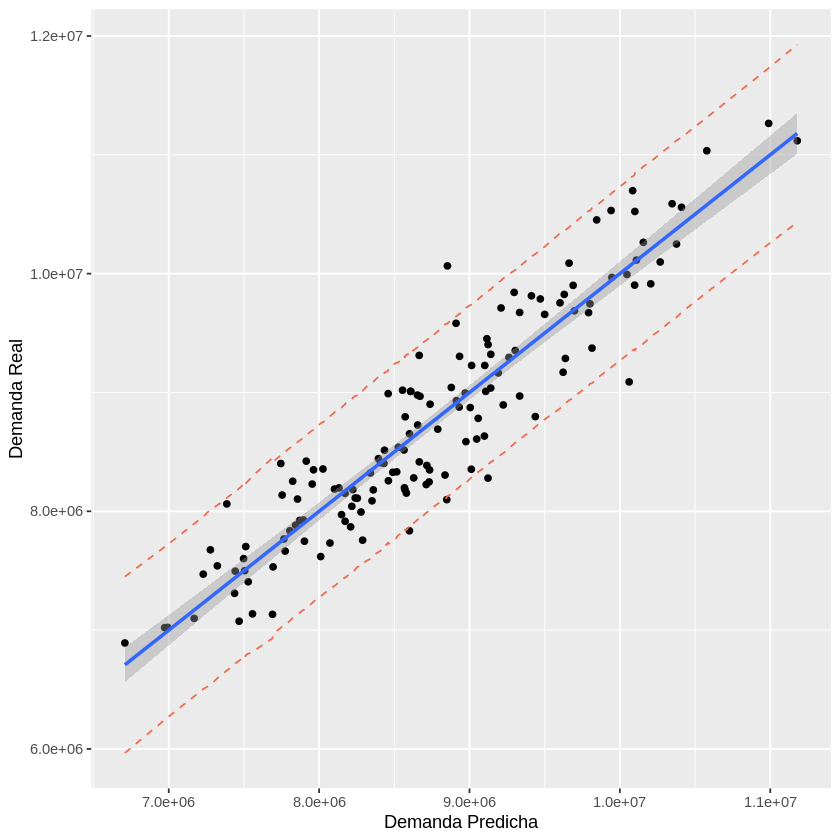

In [354]:
pred_intervals('demand', model, predictors, data)

[1] "The MAE for the subsidies estimator is 46043993.9915832"
[1] "The MAPE for the subsidies estimator is 3.15197423079741"
[1] "Max error is 180321973.459999"
[1] "Min error is -283977748.220613"
[1] "Max percentage error is 12.0412781660983"
[1] "Min percentage error is -10.7026567603499"


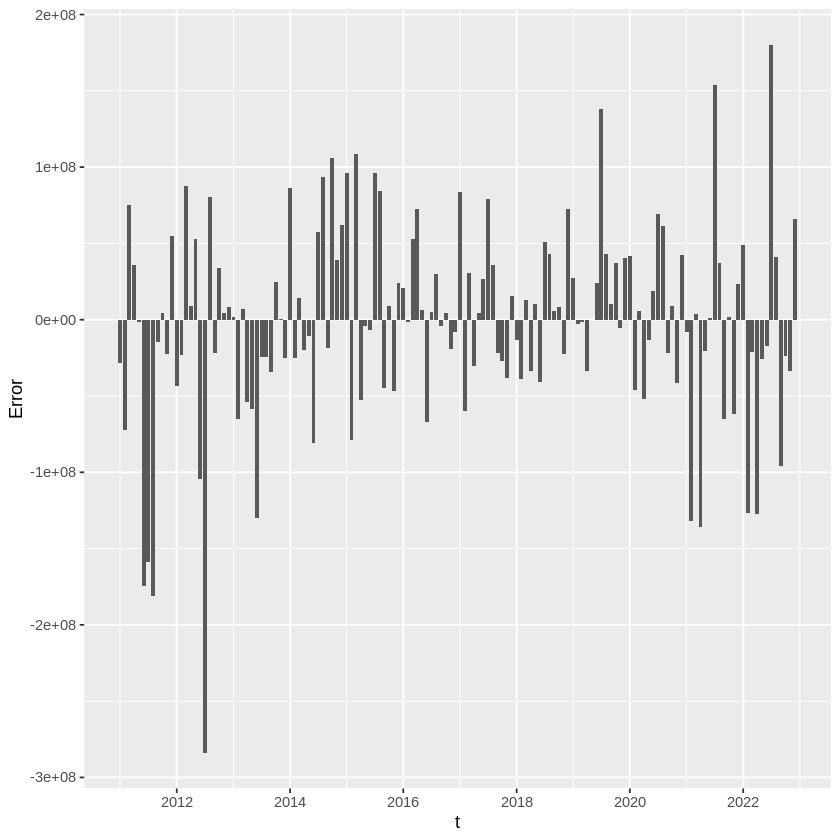

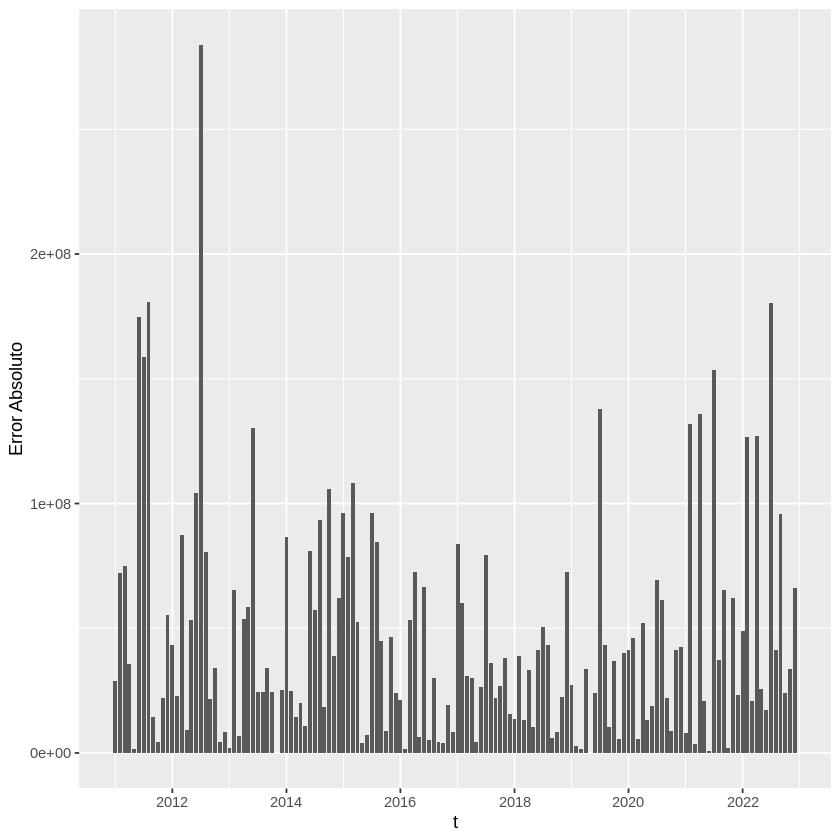

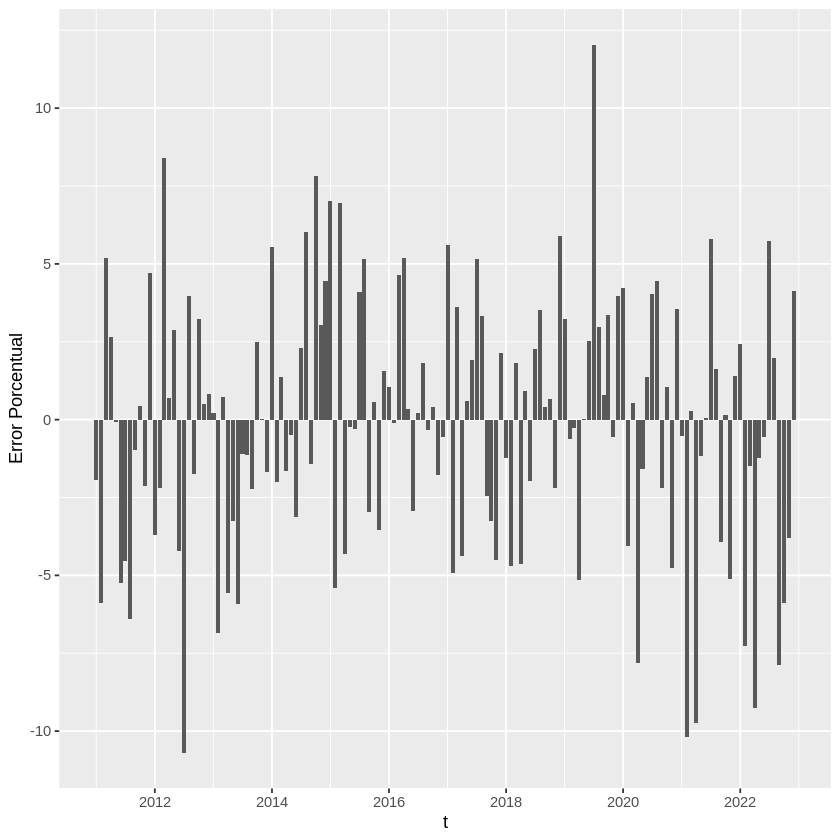

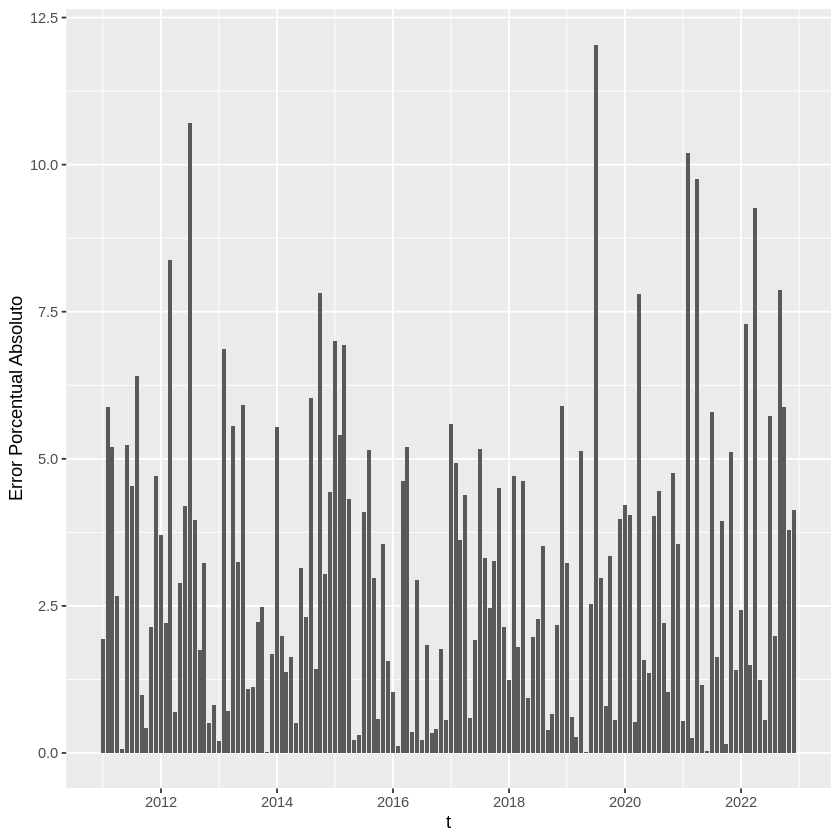

In [355]:
calc_plot_subs_errors(model, data)

In [356]:
subs_model <- build_subs_model(model, data)


Call:
lm(formula = true_subs ~ est_subs, data = data)

Residuals:
    Min      1Q  Median      3Q     Max 
-245801  -34313   -3089   32137  219187 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.281e+04  1.362e+04   2.409   0.0173 *  
est_subs    9.758e-01  8.669e-03 112.567   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63230 on 142 degrees of freedom
Multiple R-squared:  0.9889,	Adjusted R-squared:  0.9888 
F-statistic: 1.267e+04 on 1 and 142 DF,  p-value: < 2.2e-16



[1] "The p-value of the Breusch-Pagan test is 8.40556572230989e-08"
 lag Autocorrelation D-W Statistic p-value
   1      0.09636878      1.797386   0.182
 Alternative hypothesis: rho != 0


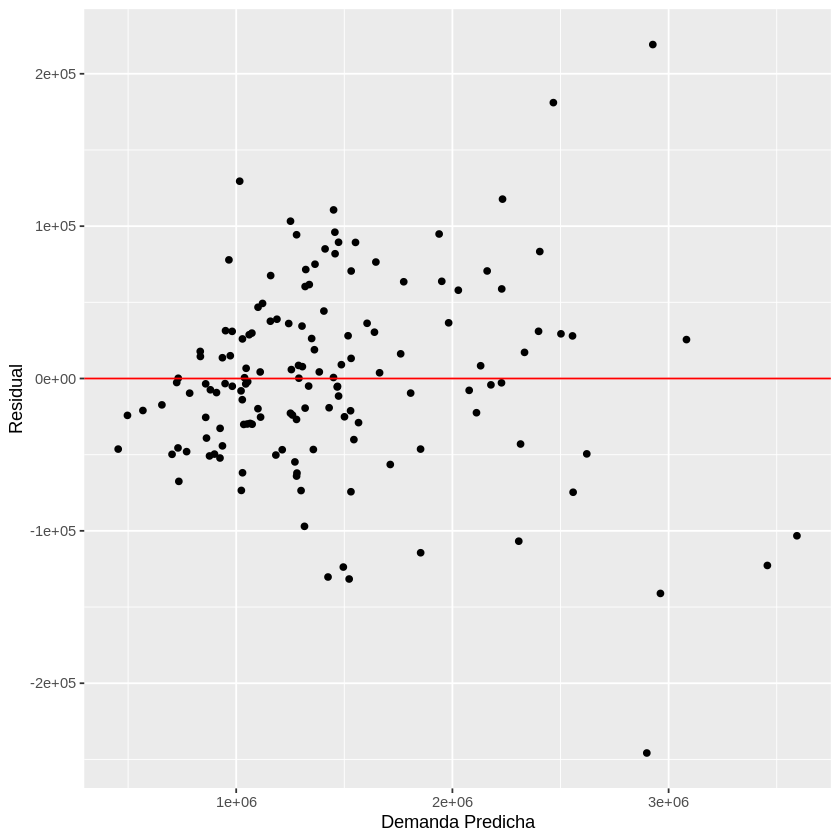

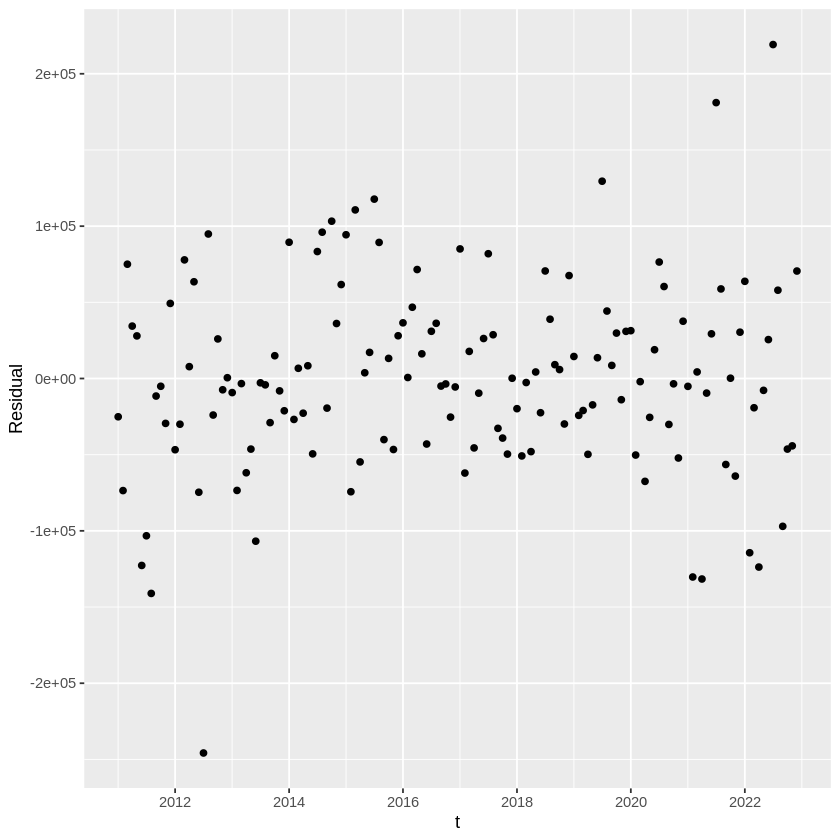

In [357]:
heterosk_test(subs_model)
autocorr_test(subs_model, data)

In [262]:
linearHypothesis(subs_model, c("(Intercept) = 0", "est_subs = 1"), vcov=vcovHC)

,Res.Df,Df,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>
1,144,NA,NA,NA
2,142,2,1.633131,0.1989639
